This notebook
* an overview of the machine learning model development process
* metrics for evaluating classification

In [4]:
import numpy as np

In [5]:
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import scipy

In [7]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
import pandas as pd

In [9]:
import seaborn as sns

In [10]:
filepath = './data/'

In [46]:
import urllib
import json
from IPython.display import display, Markdown

def generate_toc(notebook_path, indent_char="&emsp;"):
    is_markdown = lambda it: "markdown" == it["cell_type"]
    is_title = lambda it: it.strip().startswith("#") and it.strip().lstrip("#").lstrip()
    
    # Load the notebook JSON
    with open(notebook_path, 'r', encoding='utf-8') as in_f: # Use 'utf-8-sig' if necessary
        nb_json = json.load(in_f)
    
    toc_lines = []
    for cell in filter(is_markdown, nb_json["cells"]):
        for line in filter(is_title, cell["source"]):
            line = line.strip()
            indent = indent_char * (line.index(" ") - 1)
            title = line.lstrip("#").lstrip()
            url = urllib.parse.quote(title.replace(" ", "-"))
            out_line = f"{indent}[{title}](#{url})<br>\n"
            toc_lines.append(out_line)
    
    # Join the lines into a single string
    toc_output = ''.join(toc_lines)
    
    # Display the TOC in the Jupyter notebook cell
    display(Markdown(toc_output))

# Call the function with the path to your notebook
generate_toc('ML_1_evaluation.ipynb')

[ML model development process](#ML-model-development-process)<br>
[data exploration](#data-exploration)<br>
&emsp;[load data](#load-data)<br>
&emsp;[identify the columns, types, and size](#identify-the-columns%2C-types%2C-and-size)<br>
&emsp;[select which columns to use](#select-which-columns-to-use)<br>
&emsp;[deal with missing values](#deal-with-missing-values)<br>
&emsp;[identify outliers](#identify-outliers)<br>
&emsp;[check for class imbalance](#check-for-class-imbalance)<br>
[binary classification evaluation](#binary-classification-evaluation)<br>
&emsp;[TP, FP, FN, TN](#TP%2C-FP%2C-FN%2C-TN)<br>
&emsp;[accuracy, precision, recall, F1](#accuracy%2C-precision%2C-recall%2C-F1)<br>
&emsp;[ROC curve, AUC](#ROC-curve%2C-AUC)<br>
[cross validation](#cross-validation)<br>
&emsp;[`StratifiedKFold`](#%60StratifiedKFold%60)<br>
&emsp;[`Pipeline`](#%60Pipeline%60)<br>
[categorical variable encoding](#categorical-variable-encoding)<br>
&emsp;[binary variable](#binary-variable)<br>
&emsp;[multiclass variable](#multiclass-variable)<br>
&emsp;&emsp;[one-hot encoding](#one-hot-encoding)<br>
&emsp;&emsp;[integer encoding](#integer-encoding)<br>
[multiclass classification evaluation](#multiclass-classification-evaluation)<br>
&emsp;[no averaging](#no-averaging)<br>
&emsp;[macro averaging](#macro-averaging)<br>
&emsp;[micro averaging](#micro-averaging)<br>
&emsp;[weighted averaging](#weighted-averaging)<br>
[diagnosing supervised classification](#diagnosing-supervised-classification)<br>
&emsp;[overfitting, underfitting](#overfitting%2C-underfitting)<br>
&emsp;[learning curves](#learning-curves)<br>


# ML model development process

The objective here will be to understand and follow the concepts in the flow chart (and to think about if these steps make sense or not)

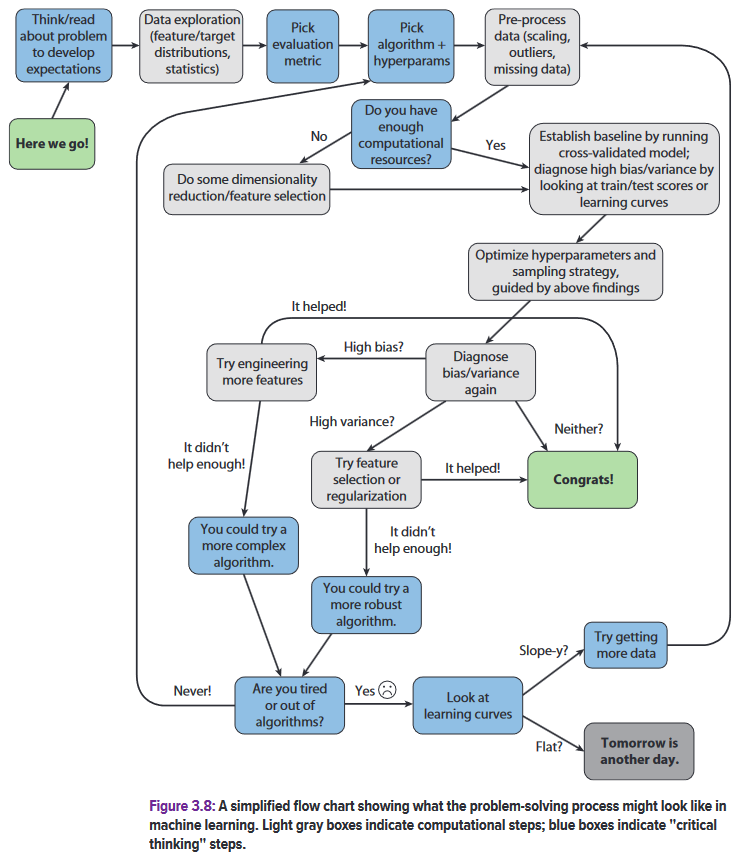

# data exploration

## load data

In [8]:
planets = pd.read_csv(filepath + 'hwc.csv', sep = ',')
# planets = original data

to keep names short but traceable, i prefer to create a dataframe for each operation or set of related operations. I add a suffix to their name (1, 2, 3,...) and leave a comment behind with info. I also avoid generic names like just `df` since i could read other data later and that would cause naming attriction. I reserve generic names for throwaway/testing variables

In [9]:
planets.head()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
0,OGLE-2016-BLG-1227L b,Microlensing,OGLE,2020,2020-04-02,250.00,-120.0,413.0,0,Mass,...,NaN,0.214133,0,0,NaN,0,NaN,Scorpius,Sco,Scorpion
1,Kepler-276 c,Transit,Kepler,2013,2018-09-25,16.60,-3.6,4.4,0,Mass,...,2.097783,0.316980,0,0,Hot,0,0.272032,Cygnus,Cyg,Swan
2,Kepler-829 b,Transit,Kepler,2016,2019-04-16,5.10,NaN,NaN,0,M-R relationship,...,1.756317,0.459559,0,0,Hot,0,0.254763,Lyra,Lyr,Lyre
3,K2-283 b,Transit,K2,2018,2019-09-05,12.20,NaN,NaN,0,M-R relationship,...,0.568374,0.443760,0,0,Hot,0,0.193906,Pisces,Psc,Fishes
4,Kepler-477 b,Transit,Kepler,2016,2019-04-16,4.94,NaN,NaN,0,M-R relationship,...,0.768502,0.386150,0,0,Hot,0,0.276721,Lyra,Lyr,Lyre


## identify the columns, types, and size

In [10]:
planets.columns

Index(['P_NAME', 'P_DETECTION', 'P_DISCOVERY_FACILITY', 'P_YEAR', 'P_UPDATE',
       'P_MASS', 'P_MASS_ERROR_MIN', 'P_MASS_ERROR_MAX', 'P_MASS_LIMIT',
       'P_MASS_ORIGIN',
       ...
       'S_ABIO_ZONE', 'S_TIDAL_LOCK', 'P_HABZONE_OPT', 'P_HABZONE_CON',
       'P_TYPE_TEMP', 'P_HABITABLE', 'P_ESI', 'S_CONSTELLATION',
       'S_CONSTELLATION_ABR', 'S_CONSTELLATION_ENG'],
      dtype='object', length=118)

Notice there's quite a lot of columns in here (118). I could to research what each means (and the units used) before moving on. eg.

S_MAG - star magnitude 

S_DISTANCE - star distance (parsecs)

S_METALLICITY - star metallicity (dex)

S_MASS - star mass (solar units)

S_RADIUS - star radius (solar units)

S_AGE - star age (Gy)

S_TEMPERATURE - star effective temperature (K)

S_LOG_G - star log(g)

P_DISTANCE - planet mean distance from the star (AU) 

P_FLUX - planet mean stellar flux (earth units)

P_PERIOD - planet period (days)

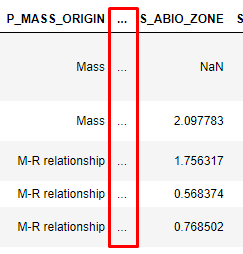

There's also missing values but we deal with them later

In [11]:
planets.dtypes

P_NAME                   object
P_DETECTION              object
P_DISCOVERY_FACILITY     object
P_YEAR                    int64
P_UPDATE                 object
                         ...   
P_HABITABLE               int64
P_ESI                   float64
S_CONSTELLATION          object
S_CONSTELLATION_ABR      object
S_CONSTELLATION_ENG      object
Length: 118, dtype: object

In [12]:
planets.shape

(5599, 118)

There's 5599 samples

In [13]:
planets.shape[0]*planets.shape[1]

660682

In [14]:
np.size(planets) # planets.size

660682

## select which columns to use

The target column is the habitability one

In [15]:
col_target = 'P_HABITABLE'
planets[col_target].head()

0    0
1    0
2    0
3    0
4    0
Name: P_HABITABLE, dtype: int64

In [16]:
planets[col_target].value_counts()

P_HABITABLE
0    5529
2      41
1      29
Name: count, dtype: int64

In [17]:
# another way of doing this

planets.groupby('P_HABITABLE').count()

,P_NAME,P_DETECTION,P_DISCOVERY_FACILITY,P_YEAR,P_UPDATE,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_MASS_LIMIT,P_MASS_ORIGIN,...,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG
P_HABITABLE,,,,,,,,,,,,,,,,,,,,,
0,5529,5529,5529,5529,5529,5522,2471,2471,5529,5529,...,5296,5306,5525,5529,5529,5295,5288,5529,5529,5529
1,29,29,29,29,29,29,16,16,29,29,...,29,29,29,29,29,29,29,29,29,29
2,41,41,41,41,41,41,19,19,41,41,...,41,41,41,41,41,41,41,41,41,41


There's non-habitable = 0, habitable-conservative = 1 and habitable-optimistic = 2

But we want to reduce this to a binary classification problem, so we group the habitable into one

In [18]:
# one way of doing that

planets2 = planets.drop('P_HABITABLE', axis = 1) # create a new data frame called planets2 without the old habitability tag
planets2['P_HABITABLE'] = (np.logical_or((planets.P_HABITABLE == 1) , (planets.P_HABITABLE == 2))) # create the new habitability tag
planets2['P_HABITABLE'] = planets2['P_HABITABLE'].astype(int) # re-cast this column as integer

# planets2 = 'P_HABITABLE' is now binary

In [19]:
planets2[col_target].value_counts()

P_HABITABLE
0    5529
1      70
Name: count, dtype: int64

In [20]:
# other 2 ways of doing the same thing

# `apply()` and lambda function
planets2 = planets.drop('P_HABITABLE', axis=1)
planets2['P_HABITABLE'] = planets['P_HABITABLE'].apply(lambda x: 1 if x in [1, 2] else 0)

# `replace()`
planets2 = planets.drop('P_HABITABLE', axis=1)
planets2['P_HABITABLE'] = planets['P_HABITABLE'].replace({1: 1, 2: 1}).astype(int)

we also need to decide what other columns we want

In [21]:
cols_selected = ['S_MASS', 'P_PERIOD', 'P_DISTANCE', col_target]
planets3 = planets2[cols_selected]
planets3.head()

# planets3 = dataframe with only 'S_MASS', 'P_PERIOD', 'P_DISTANCE', 'P_HABITABLE'

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,0.10,NaN,3.4000,0
1,1.10,31.884000,0.1994,0
2,0.98,6.883376,0.0678,0
3,0.89,1.921036,0.0291,0
4,0.87,11.119907,0.0911,0


In [22]:
print(planets2.shape[1] - planets3.shape[1], "columns removed")

114 columns removed


## deal with missing values

missing values are `NaN`s or `None`s

There are various ways of identifying them

In [23]:
# isnull() or isna()
# return a dataframe of the same shape, with True where the values are missing and False where they are not
value_is_missing = planets3.isnull()  # or df.isna()
value_is_missing

# this is useful as a filter

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,False,True,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
5594,False,False,False,False
5595,False,False,False,False
5596,False,False,False,False
5597,False,False,False,False


In [24]:
# find columns with any missing values
cols_with_missing = value_is_missing.any()
cols_with_missing

S_MASS          True
P_PERIOD        True
P_DISTANCE      True
P_HABITABLE    False
dtype: bool

In [25]:
# # find rows with any missing values
rows_with_missing = value_is_missing.any(axis=1)

In [26]:
# count the number of missing values

# in each column
missing_count_per_col = value_is_missing.sum()
print(missing_count_per_col)

# total
print(sum(missing_count_per_col))

S_MASS           4
P_PERIOD       249
P_DISTANCE       4
P_HABITABLE      0
dtype: int64
257


In [27]:
# get the indices of missing values
missing_indices = planets3[rows_with_missing]
missing_indices

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
0,0.10,NaN,3.400,0
21,0.38,NaN,2.700,0
599,0.06,NaN,0.681,0
607,1.22,NaN,43.500,0
608,0.40,NaN,52.000,0
...,...,...,...,...
5575,0.91,NaN,1.840,0
5576,0.66,NaN,6.990,0
5591,0.39,NaN,2.440,0
5593,0.53,NaN,1.900,0


Once identified, you have to deal with them. There is no unique strategy to handle missing values.
* the most draconian option is to `discard` objects for which any of the features are missing, but this of course implies throwing away data, which is never ideal.
* another possible choice is to replace the missing value with some plausible estimate (called `imputing` in ML jargon), for example, the mean or median of that feature, or some plausible value coming from building a predictive model of the missing values (e.g., with a kNN!), using the other features as input 

In [28]:
# Manually remove missing values

# Identify missing values - create a boolean mask of rows (indices)
# True for rows with missing values
missing_mask = planets3.isnull().any(axis=1)

# Use the boolean mask to filter out rows
# keep only rows where missing_mask is False (i.e., no NaN)
planets4 = planets3[~missing_mask]

# planets4 = all missing values removed

In [29]:
# Remove rows with any missing values
df = planets3.dropna() # this is axis=0. axis=1 removes entire columns

In [30]:
# Remove rows with missing values in a specific column
df = planets3.dropna(subset=['P_PERIOD'])

In [31]:
planets4.shape

(5350, 4)

In [32]:
print(planets3.shape[0] - planets4.shape[0], "rows removed")

249 rows removed


However, notice that if we had separated the data into $X$ and $y$, we would now have to remove the corresponding entries from $y$, which we could do like this

In [33]:
y = planets.P_HABITABLE
X = planets[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
X2 = X.dropna()

# Get the indices of the rows that remain after dropping NaN in X
indices = X2.index

# Use the same indices to filter the y vector
y2 = y.loc[indices]

print(X2.shape, y2.shape)

(5350, 3) (5350,)


in terms of keeping up with the variables names this is not ideal because the effects on $y$ will only be seen after row operations, and column operations won't be tracked. Imo, it's better that, if you want to ignore the targets when filtering, you do that explicitly.

## identify outliers

* https://en.wikipedia.org/wiki/Outlier

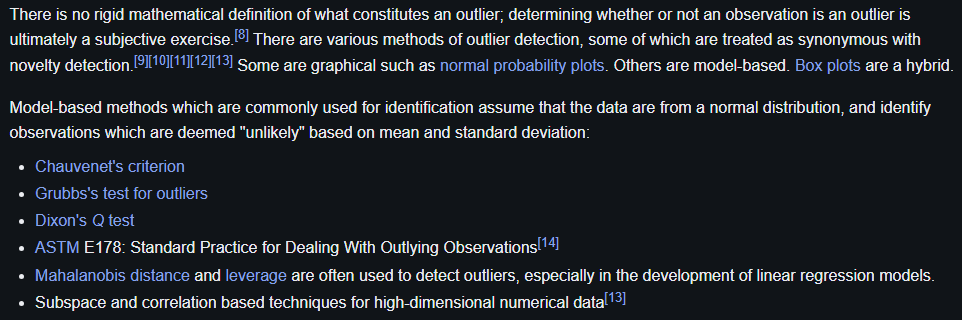

methods for outlier detection:
* statistical: Z-score, IQR
* visual: Box plot, Scatter plot
* machine learning: Isolation Forest, Local Outlier Factor (LOF)

The distributions of the features are quite skewed, and there are several `outliers`. These characteristics can be shown by plotting each feature as a histogram or just by using the `describe()` property of data frames in pandas and noticing that the mean and median of each distribution are quite far from each other. 

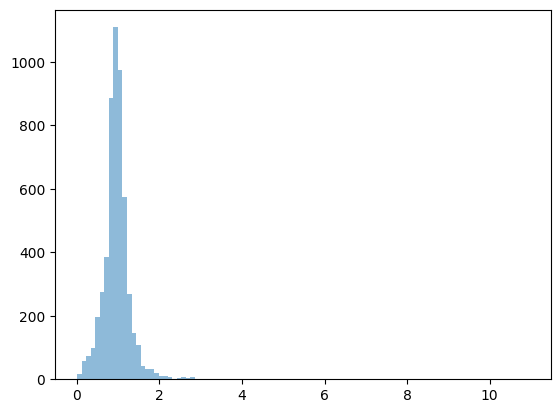

In [34]:
# histogram for the 1st feature
plt.hist(planets4.iloc[:,0], bins = 100, alpha = 0.5)
plt.show()

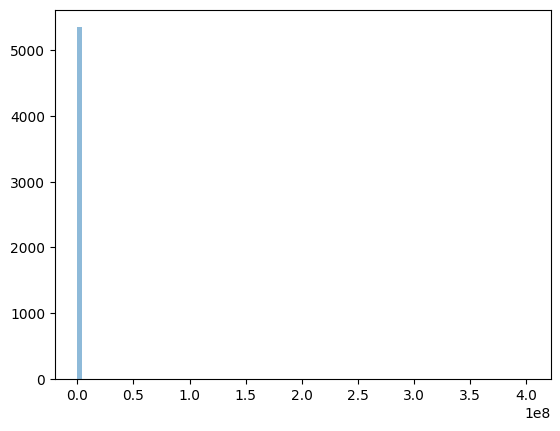

In [35]:
plt.hist(planets4.iloc[:,1], bins = 100, alpha = 0.5)
plt.show()

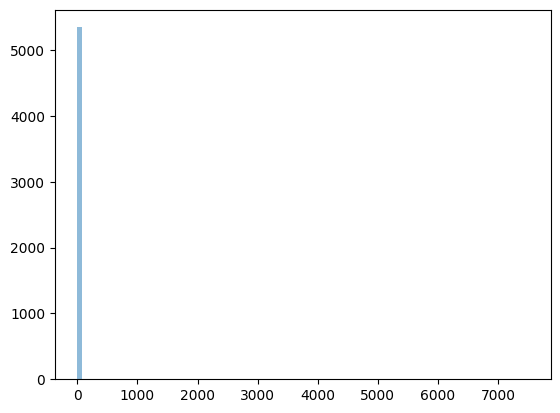

In [36]:
plt.hist(planets4.iloc[:,2], bins = 100, alpha = 0.5)
plt.show()

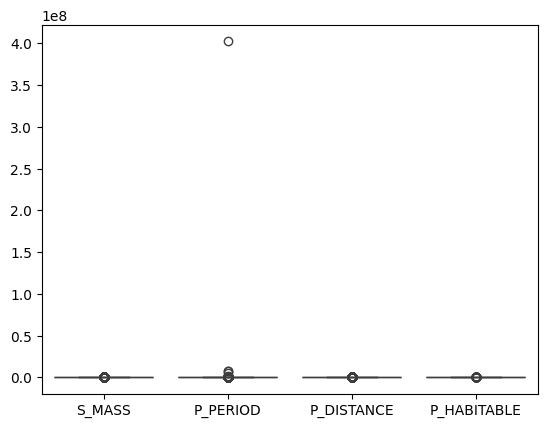

In [37]:
# Create a box plot for each column
sns.boxplot(data=planets4)
plt.show()
# Outliers will be displayed as individual points outside the whiskers.

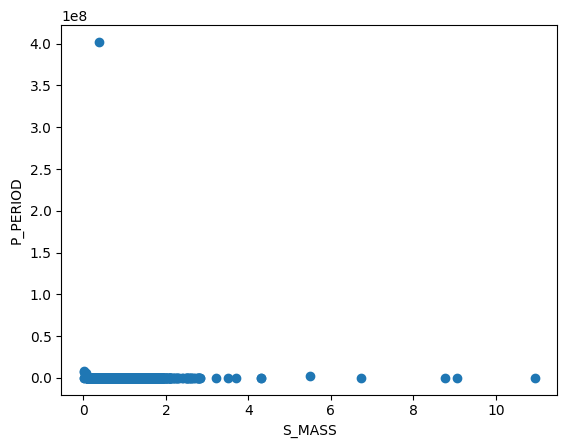

In [38]:
# For bivariate data, a scatter plot can help visualize outliers.
plt.scatter(planets4.iloc[:, 0], planets4.iloc[:, 1])
plt.xlabel(planets4.columns[0])
plt.ylabel(planets4.columns[1])
plt.show()

# Outliers are points that appear far from the main cluster

In [39]:
planets4.describe()

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
count,5350.000000,5.350000e+03,5350.000000,5350.000000
mean,0.967725,7.994082e+04,2.298436,0.013084
std,0.394993,5.498596e+06,103.218178,0.113646
min,0.010000,9.070629e-02,0.004408,0.000000
25%,0.810000,4.465382e+00,0.051900,0.000000
50%,0.950000,1.156951e+01,0.096550,0.000000
75%,1.100000,4.150555e+01,0.232000,0.000000
max,10.940000,4.020000e+08,7506.000000,1.000000


The `IQR` method focuses on the middle 50% of the data (the range between the 25th and 75th percentiles). Any point outside 1.5 times the IQR is considered an outlier

In [40]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = planets4.quantile(0.25)
Q1

S_MASS         0.810000
P_PERIOD       4.465382
P_DISTANCE     0.051900
P_HABITABLE    0.000000
Name: 0.25, dtype: float64

In [41]:
Q3 = planets4.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
value_is_outlier = ((planets4 < lower_bound) | (planets4 > upper_bound))
value_is_outlier

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
5,False,False,False,False
...,...,...,...,...
5592,False,False,False,False
5594,False,True,True,False
5595,False,True,True,False
5596,False,False,False,False


In [42]:
value_is_outlier.sum().sum()

np.int64(2239)

Having identified outliers, we can opt to eliminate them. In particular, "severe outliers" might "skew" decisions made by our classifiers

This exclusion based on IQR would eliminate a lot of the data. Ofc, since there is no strict definition, we could ajust the lower and upper bound (for eg. to $3 \; \text{IQR}$ instead of $1.5 \; \text{IQR}$)

In [43]:
def my_outliers_IQR(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers_mask = ((df < lower_bound) | (df > upper_bound))
    
    # Rows that have at least one outlier
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers
    df_clean = df[~row_has_outlier]  # Without outliers
    df_outliers = df[row_has_outlier]  # Only outliers
    
    return df_clean, df_outliers

In [44]:
# version to ignore target columns

def my_outliers_IQR(df, ignore_columns=None):
    # If no columns to ignore, default to an empty list
    if ignore_columns is None:
        ignore_columns = []
    
    # Select the columns to consider for outlier detection
    columns_to_check = [col for col in df.columns if col not in ignore_columns]
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for the selected columns
    Q1 = df[columns_to_check].quantile(0.25)
    Q3 = df[columns_to_check].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers in the selected columns
    outliers_mask = ((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound))
    
    # Rows that have at least one outlier in the selected columns
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers (include all columns in the final result)
    df_clean = df[~row_has_outlier]  # Rows without outliers
    df_outliers = df[row_has_outlier]  # Rows with outliers

    return df_clean, df_outliers

In [45]:
df_clean, df_outliers = my_outliers_IQR(planets4, ignore_columns=[col_target])

The Z-score method works by excluding objects whose `z-score` (distance from mean, calculated in units of standard deviation) is larger than some desired value

The Z-score indicates how many standard deviations a data point is from the mean. Data points with a Z-score greater than a threshold (typically 3) are considered outliers.

In [46]:
columns_to_check = [col for col in df.columns if col != col_target]

In [47]:
# Calculate Z-scores for each column
z_scores = np.abs((planets4[columns_to_check] - planets4[columns_to_check].mean()) / planets4[columns_to_check].std())
z_scores.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,0.334879,0.014533,0.020336
2,0.031076,0.014537,0.021611
3,0.196776,0.014538,0.021986
4,0.247410,0.014536,0.021385
5,0.728431,0.014537,0.021631


In [48]:
# (same thing, using scipy)
z_scores = scipy.stats.zscore(planets4[columns_to_check])
z_scores.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,0.334910,-0.014534,-0.020338
2,0.031079,-0.014539,-0.021613
3,-0.196795,-0.014539,-0.021988
4,-0.247433,-0.014538,-0.021387
5,-0.728500,-0.014538,-0.021633


In [49]:
# Set threshold to 5
threshold = 5

# Find outliers
value_is_outlier = (z_scores > threshold)
value_is_outlier.head()

,S_MASS,P_PERIOD,P_DISTANCE
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False


In [50]:
# number of outliers
value_is_outlier.sum().sum()

np.int64(13)

In [51]:
# rows with outliers
row_has_outlier = value_is_outlier.any(axis=1)
row_has_outlier

1       False
2       False
3       False
4       False
5       False
        ...  
5592    False
5594    False
5595    False
5596    False
5597    False
Length: 5350, dtype: bool

In [52]:
# manually remove them
planets5 = planets4[~row_has_outlier]

# planets5 = outliers were removed

In [53]:
def my_outliers_zscore(df, threshold=3, ignore_columns=None):
    
    # If no columns to ignore, default to an empty list
    if ignore_columns is None:
        ignore_columns = []
    
    # Select the columns to consider for outlier detection
    columns_to_check = [col for col in df.columns if col not in ignore_columns]
    
    # Calculate Z-scores for each column
    z_scores = np.abs((df[columns_to_check] - df[columns_to_check].mean()) / df[columns_to_check].std())

    # Find outliers
    outliers_mask = (z_scores > threshold)
    
    # Rows that have at least one outlier
    row_has_outlier = outliers_mask.any(axis=1)
    
    # DataFrames for rows with and without outliers
    df_clean = df[~row_has_outlier]  # Without outliers
    df_outliers = df[row_has_outlier]  # Only outliers

    return df_clean, df_outliers

In [54]:
planets5.shape

(5339, 4)

In [55]:
print(planets4.shape[0] - planets5.shape[0], "rows removed")

11 rows removed


## check for class imbalance

in supervised classification, the classifier should be trained with a `balanced dataset`, that is, with data with the same number of examples for each class

In [56]:
planets5[col_target].value_counts()

P_HABITABLE
0    5269
1      70
Name: count, dtype: int64

Our data is very imbalanced, with many more examples of nonhabitable planets (0) than habitable ones (1)

In [57]:
planets5.groupby(col_target).describe(percentiles = [])

S_MASS                                       P_PERIOD  \
              count      mean       std   min   50%   max    count   
P_HABITABLE                                                          
0            5269.0  0.965409  0.304768  0.01  0.96  2.82   5269.0   
1              70.0  0.431714  0.247650  0.09  0.42  1.04     70.0   

                                                                          \
                    mean            std       min       50%          max   
P_HABITABLE                                                                
0            4532.574018  169610.983874  0.090706  11.33200  8040000.000   
1              73.921945      80.613442  4.049219  36.76998      384.843   

            P_DISTANCE                                                 
                 count      mean       std       min     50%      max  
P_HABITABLE                                                            
0               5269.0  0.788638  7.702383  0.004408  0.0958  430.920  
1                 70.0  0.255224  0.233825  0.022271  0.1647    1.046

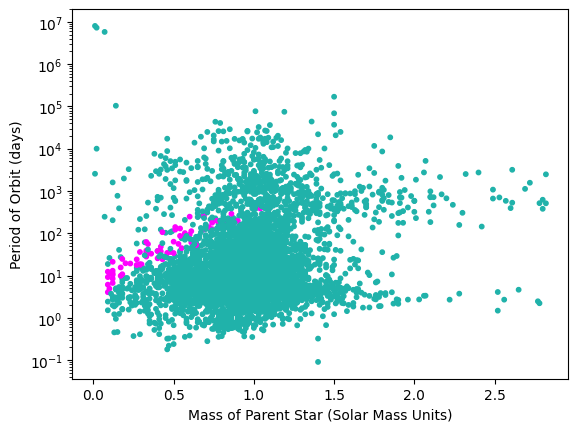

In [58]:
# plot two variables (numeric) with the target variable (categorical) as hue

# Define a color map for the target column (e.g., 0 and 1)
colors = {0: '#20B2AA', 1: '#FF00FF'}  # Customize colors for different target values

# Map the target values to the corresponding colors
color_values = planets5[col_target].map(colors)

# Create the scatter plot with the mapped colors
plt.scatter(planets5['S_MASS'], planets5['P_PERIOD'], 
            marker='o', c=color_values, s=10)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Set plot labels
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)')

# Show the plot
plt.show()

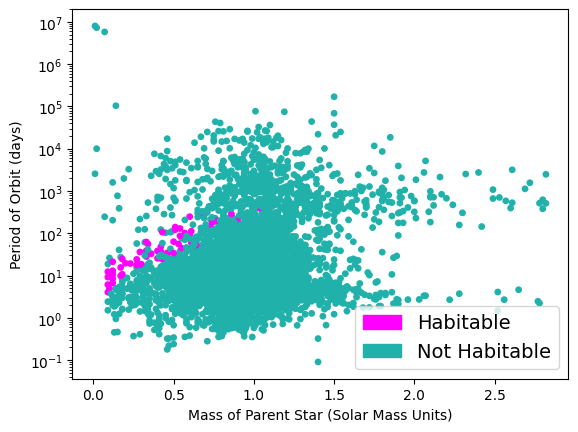

In [59]:
# to create a legend for the thing above, use mpatches
import matplotlib.patches as mpatches

# Define a color map for the target column (e.g., 0 and 1)
colors = {0: '#20B2AA', 1: '#FF00FF'}  # Customize colors for different target values

# Map the target values to the corresponding colors
color_values = planets5[col_target].map(colors)

# Create the scatter plot with the mapped colors
plt.scatter(planets5['S_MASS'], planets5['P_PERIOD'], 
            marker='o', c=color_values, s=15)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Set plot labels
plt.xlabel('Mass of Parent Star (Solar Mass Units)')
plt.ylabel('Period of Orbit (days)')

# Create legend manually
habitable_patch = mpatches.Patch(color='#FF00FF', label='Habitable')
not_habitable_patch = mpatches.Patch(color='#20B2AA', label='Not Habitable')
plt.legend(handles=[habitable_patch, not_habitable_patch], loc='lower right', fontsize=14)

# Show the plot
plt.show()

# binary classification evaluation

## TP, FP, FN, TN

* consider a group with P positive instances and N negative instances of some condition. The four outcomes can be formulated in a 2×2 contingency table or confusion matrix

    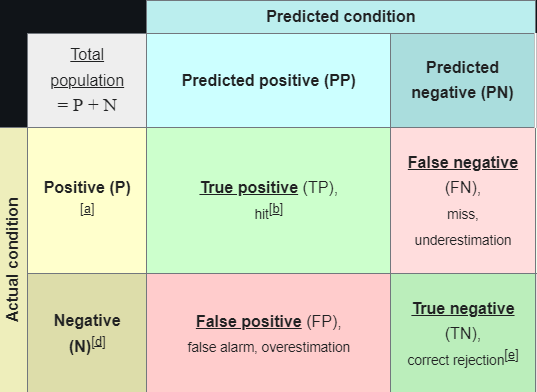

actual positive $P = TP + FN$

actual negative $N = FP + TN$

total $|y| = P + N$

predicted positive $PP = TP + FP$

predicted negative $PN = FN + TN$

* `confusion matrix`

    This matrix, which is 2 × 2 for a binary classifier, is built by comparing the predicted labels (typically plotted as columns) and the ground truth (typically plotted as rows).

* for a binary classifier, once we have assigned a "positive" label to one class and a "negative" label to another, any metric will be defined in terms of four numbers: the amount of `true positives (TP)`, `true negatives (TN)`, `false positives (FP)`, and `false negatives (FN)`

* the second word (positive/negative) is the classification assigned by the model, and the first word indicates whether such classification is correct (true), or incorrect (false). 

    I find it a bit confusing that the intrinsic label (ground truth) is not actually spelled out, so I tend to paraphrase these in my head as "correctly classified as positive", "correctly classified as negative", "incorrectly classified as positive", and "incorrectly classified as negative".

In [60]:
def my_binary_confusion_matrix(y_true, y_pred):
    # assumes enconding is true = 1, false = 0
    encoding = {'True': 1, 'False': 0}
    
    # True Positives (TP): Actual Positive (1) and Predicted Positive (1)
    TP = np.sum((y_true == encoding['True']) & (y_pred == encoding['True']))
    
    # False Positives (FP): Actual Negative (0) but Predicted Positive (1)
    FP = np.sum((y_true == encoding['False']) & (y_pred == encoding['True']))
    
    # False Negatives (FN): Actual Positive (1) but Predicted Negative (0)
    FN = np.sum((y_true == encoding['True']) & (y_pred == encoding['False']))
    
    # True Negatives (TN): Actual Negative (0) and Predicted Negative (0)
    TN = np.sum((y_true == encoding['False']) & (y_pred == encoding['False']))

    # Confusion Matrix
    # confusion_matrix = np.array([[TP, FN],  # First row: TP, FN
    #                            [FP, TN]]) # Second row: FP, TN
    confusion_matrix = {'TP': TP, 'FN': FN, 'FP': FP, 'TN': TN}
    
    return confusion_matrix

In [61]:
y_true = np.array([1, 0, 1, 1, 0, 0, 1, 0])
y_pred = np.array([1, 0, 1, 0, 0, 1, 1, 0])

conf_matrix = my_binary_confusion_matrix(y_true, y_pred)
conf_matrix

{'TP': np.int64(3), 'FN': np.int64(1), 'FP': np.int64(1), 'TN': np.int64(3)}

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[3, 1],
       [1, 3]])

In [63]:
# In the binary case, we can extract true positives, etc. as follows
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

From these, we can compute all these things...

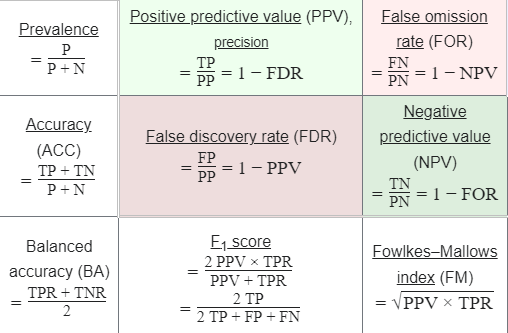
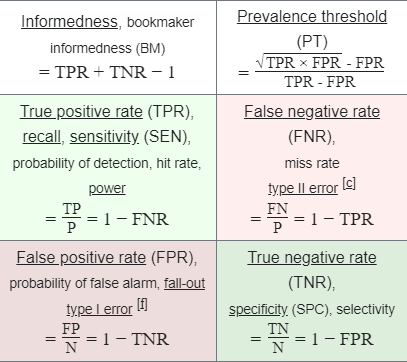
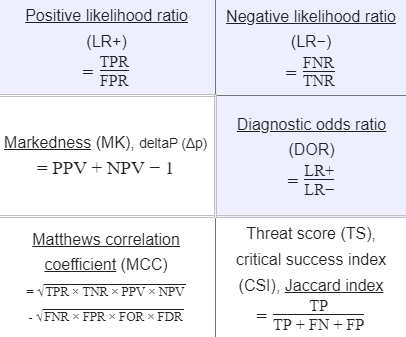

## accuracy, precision, recall, F1

From all these, the most "popular" are:
* accuracy
* precision
* recall
* F1 score

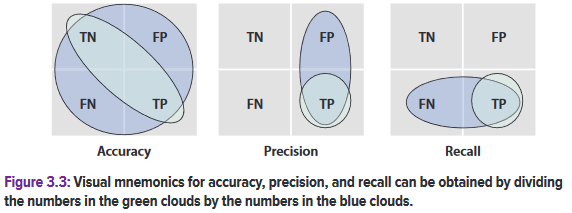

their computation aside, accuracy and precision are commonly used and well known concepts from daily life

<div>
    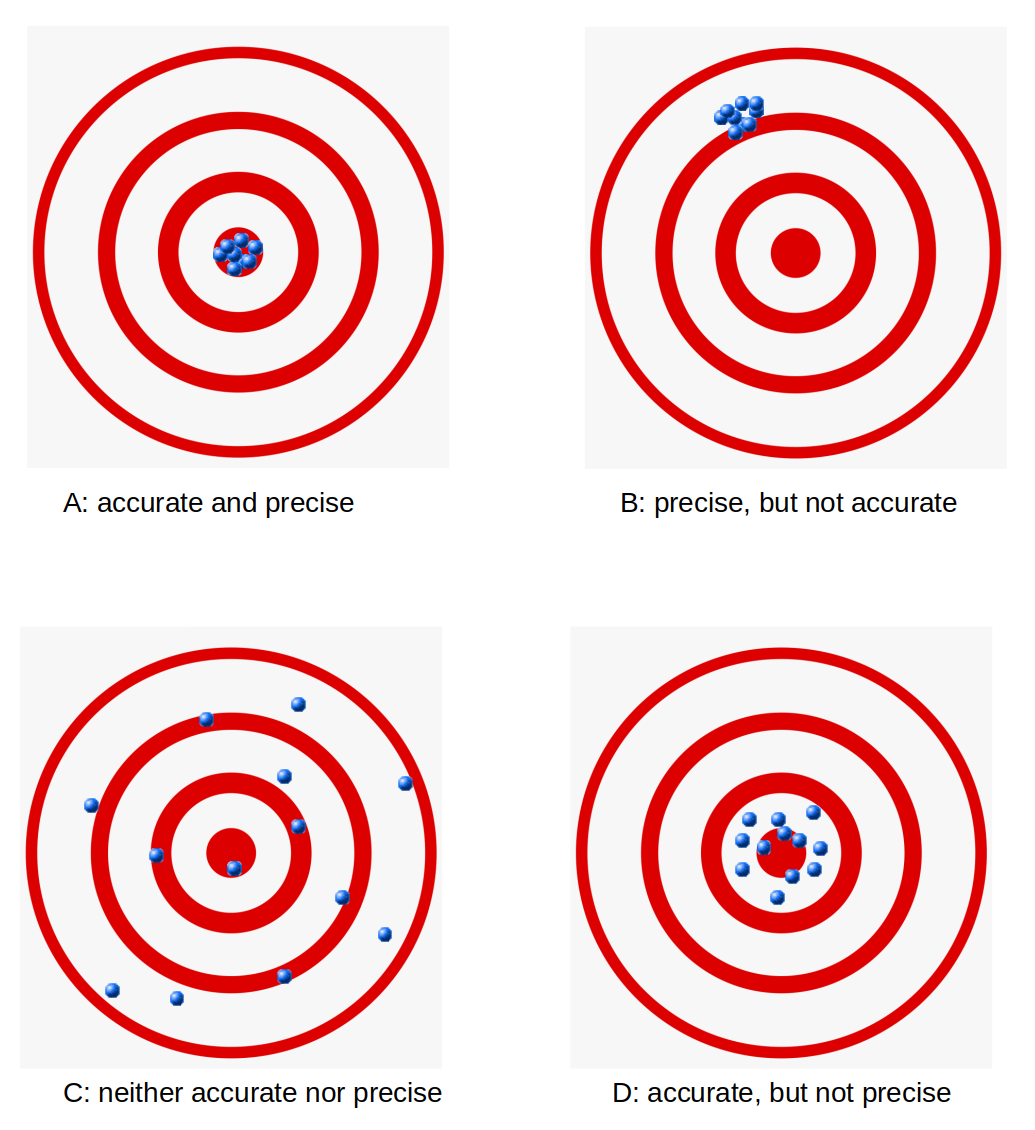
</div>

`accuracy`

$\text{ACC} = \Large \frac{\text{# correct classifications}}{\text{# all classifications}} 
\normalsize
\overset{y \; \text{is binary}}{\implies} \frac{TN + TP}{|y|}
$

In [64]:
# assumes binary confusion matrix
def my_acc(confusion_matrix):
    TP = confusion_matrix['TP']
    FN = confusion_matrix['FN']
    FP = confusion_matrix['FP']
    TN = confusion_matrix['TN']
    return (TN + TP)/(TN + TP + FN + FP)

In [65]:
# more general, because not restricted to the binary case
def my_acc(y_true, y_pred):
    return np.sum(y_pred == y_true)/len(y_pred)

In [66]:
# applicable to multiclass if the concepts can be generalized
def my_acc(TP, FN, FP, TN):
    return (TN + TP)/(TN + TP + FN + FP)

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.75

`precision` (or `positive predictive value`)

$\text{precision} = \text{PPV} = \frac{TP}{FP + TP}$

meaning: Out of all the examples that have been classified as belonging to the positive class, how many of those truly belong to the positive class?

In [68]:
def my_precision(*args):
    if len(args) == 1 and isinstance(args[0], dict):  # confusion matrix version
        confusion_matrix = args[0]
        TP = confusion_matrix['TP']
        FP = confusion_matrix['FP']
    elif len(args) == 2:  # separate arguments
        TP = args[0]
        FP = args[1]
    else:
        raise ValueError("Invalid arguments: Provide a confusion matrix or TP and FN values.")

    # PPV = TP / (FP + TP)
    if (FP + TP) == 0:
        return 0  # Avoid division by zero
    return TP / (FP + TP)

In [69]:
from sklearn.metrics import precision_score
precision_score(y_true, y_pred)

np.float64(0.75)

`recall` (or `sensitivity`/`true positive rate`) = rate of true positives

$\text{recall} = \text{TPR} = \frac{TP}{P}= \frac{TP}{TP + FN}$

meaning: Out of the totality of objects that truly belong to the positive class, how many of them has our model captured?

In [70]:
def my_recall(*args):
    if len(args) == 1 and isinstance(args[0], dict):  # confusion matrix version
        confusion_matrix = args[0]
        TP = confusion_matrix['TP']
        FN = confusion_matrix['FN']
    elif len(args) == 2:  # separate arguments
        TP = args[0]
        FN = args[1]
    else:
        raise ValueError("Invalid arguments: Provide a confusion matrix or TP and FN values.")

    # PPV = TP / (FP + TP)
    if (FN + TP) == 0:
        return 0  # Avoid division by zero
    return TP / (FN + TP)

In [71]:
from sklearn.metrics import recall_score
recall_score(y_true, y_pred)

np.float64(0.75)

* maximizing precision is useful when we want high purity in the proposed sample of positive classifications. 

    Precision is sensitive to false positives only, so a high precision ensures that each positive classification comes with high confidence. This happens at the cost of some positive examples being "missed" by the classifier or, in other words, a higher rate of FNs, which translates into lower recall.

* maximizing recall is often associated with the search for rare objects

    in this case, we tend to care more about "catching" all possible positive examples by casting a wider net, which will minimize the number of false negatives and ensure completeness. The flip side is the resulting lower purity of our sample of proposed positive classifications (i.e., lower precision, or a higher rate of FPs).

`F1 score` is the harmonic mean (a weighted combination) of precision and recall, balancing these two metrics.

$F_1 = 2 \Large\frac{\text{precision} \; \times \; \text{recall}}{\text{precision} \; + \;  \text{recall}}=\frac{2 \; TP}{2 \; TP + FP + FN}$

In [72]:
def my_f1_score(precision, recall):
    return 2*precision*recall/(precision + recall)

In [73]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred)

np.float64(0.75)

You should probably memorize these. Others that will be relevant later:
* `specificity`/`true negative rate` $\text{TNR} = \frac{TN}{N}$
* `type I error`/`false positive rate` $\text{FPR} = \frac{FP}{N}$
* `type II error`/`false negative rate` $\text{FNR} = \frac{FN}{P}$

In [74]:
def my_fpr(*args):
    if len(args) == 1 and isinstance(args[0], dict):  # Confusion matrix version
        confusion_matrix = args[0]
        FP = confusion_matrix['FP']
        TN = confusion_matrix['TN']
    elif len(args) == 2:  # TP and FN as separate arguments
        TP = args[0]
        FN = args[1]
    else:
        raise ValueError("Invalid arguments: Provide a confusion matrix or TP and FN values.")

    # FPR = FP / (FP + TN)
    if (FP + TN) == 0:
        return 0  # Avoid division by zero
    return FP / (FP + TN)

## ROC curve, AUC

Another commonly used metric to evaluate the performance of a classification model and to compare different models is the `receiver operating characteristic curve`, or `ROC curve`
* built by plotting the rate of false positives ($FPR$) versus the rate of true positives (recall, $TPR$). 
* for different values of the threshold, varying between 1 (no object is classified as positive, so FP = 0 and TP = 0) and 0 (all objects are classified as positive, so TN = 0), the values of the curve vary between (0,0) and (1,1)
* for highly predictive models, the curve will rise sharply and approach the "perfect classifier" case, which has a close-to-zero FP rate and close-to-one TP rate (point (0,1) in the ROC diagram). For nonpredictive models, the curve will stay closer to the diagonal line. 
* for this reason, the area `under the curve (AUC)` is often used to summarize the performance of a model and to compare different models across a range of possible choices of threshold

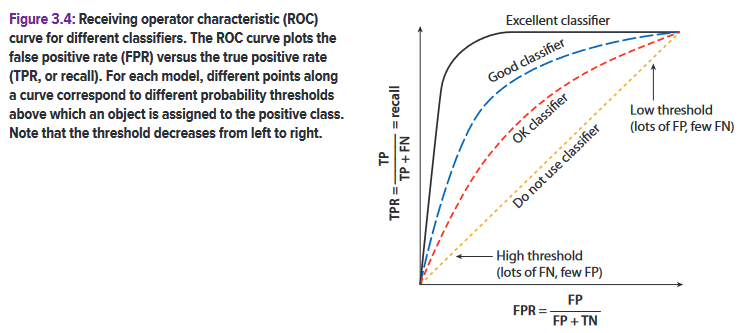

In [75]:
# using sklearn

from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_prob):
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

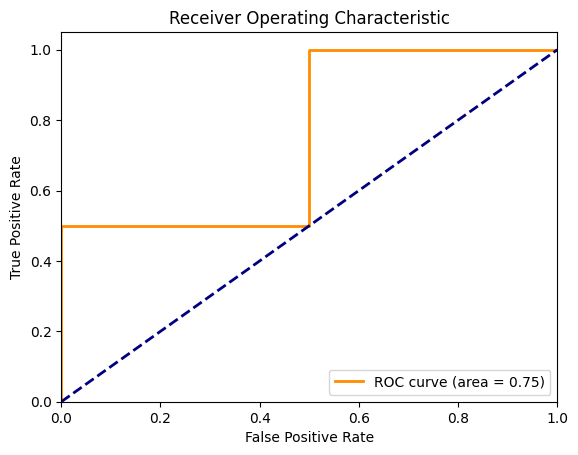

In [76]:
# Example usage:
# y_true = actual binary labels (0 or 1)
# y_prob = predicted probabilities from the classifier (continuous values)

y_true = np.array([0, 0, 1, 1])
y_prob = np.array([0.1, 0.4, 0.35, 0.8])
plot_roc_curve(y_true, y_prob)

This curve looks stupid but gets the idea across i think

In [77]:
# "diy"

def my_roc(y_true, y_prob):
    # Sort thresholds in descending order
    thresholds = np.sort(np.unique(y_prob))[::-1]
    
    tpr_list = []
    fpr_list = []
    
    for threshold in thresholds:
        # Convert probabilities to binary predictions based on the threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate confusion matrix for the current threshold
        confusion_matrix = my_binary_confusion_matrix(y_true, y_pred)
        
        # Calculate TPR and FPR
        tpr = my_recall(confusion_matrix)
        fpr = my_fpr(confusion_matrix)
        
        # Append the TPR and FPR for this threshold
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    return fpr_list, tpr_list, thresholds


def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

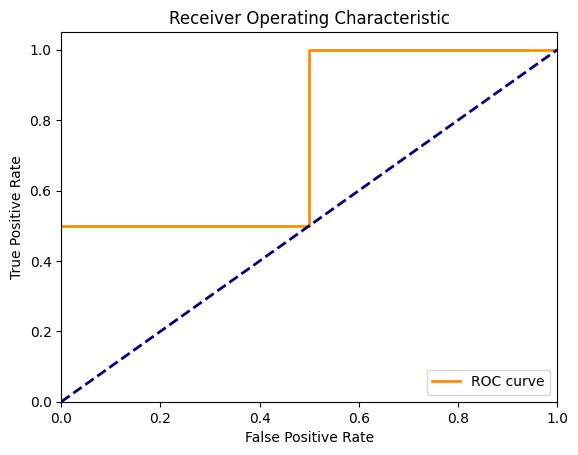

Threshold: 0.80, TPR: 0.50, FPR: 0.00
Threshold: 0.40, TPR: 0.50, FPR: 0.50
Threshold: 0.35, TPR: 1.00, FPR: 0.50
Threshold: 0.10, TPR: 1.00, FPR: 1.00


In [78]:
# Example usage
y_true = np.array([0, 0, 1, 1])  # True binary labels
y_prob = np.array([0.1, 0.4, 0.35, 0.8])  # Predicted probabilities

fpr, tpr, thresholds = my_roc(y_true, y_prob)
plot_roc_curve(fpr, tpr)

# You can also print FPR, TPR, and thresholds to inspect:
for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]:.2f}, TPR: {tpr[i]:.2f}, FPR: {fpr[i]:.2f}")

calculation the area under the curve can be done with many different numerical integration methods

In [79]:
def calculate_auc_trapezoidal(fpr, tpr):
    
    # Calculates the Area Under the Curve (AUC) using the trapezoidal rule.
    
    auc = 0.0
    for i in range(1, len(fpr)):
        # Calculate the width (difference in FPR) and height (average of two TPR points)
        width = fpr[i] - fpr[i-1]
        height = (tpr[i] + tpr[i-1]) / 2
        auc += width * height
    
    return auc

In [80]:
auc_value = calculate_auc_trapezoidal(fpr, tpr)
print(f"AUC: {auc_value:.2f}")

AUC: 0.75


In sklearn, instead of asking for the predictions/labels directly (with `.predict`), i ask for the probabilities now (with `.predict_proba`)

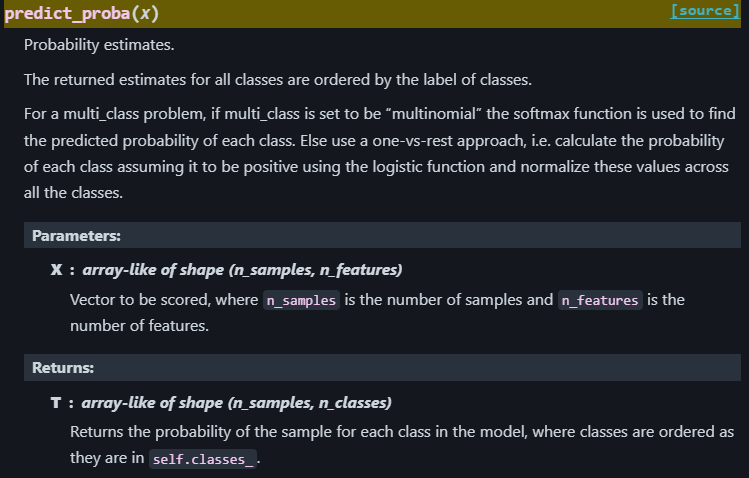

In [81]:
planets5.head()

,S_MASS,P_PERIOD,P_DISTANCE,P_HABITABLE
1,1.10,31.884000,0.1994,0
2,0.98,6.883376,0.0678,0
3,0.89,1.921036,0.0291,0
4,0.87,11.119907,0.0911,0
5,0.68,7.493134,0.0657,0


In [82]:
planets5.dtypes

S_MASS         float64
P_PERIOD       float64
P_DISTANCE     float64
P_HABITABLE      int64
dtype: object

Decision Tree Classifier AUC: 0.8664799253034547


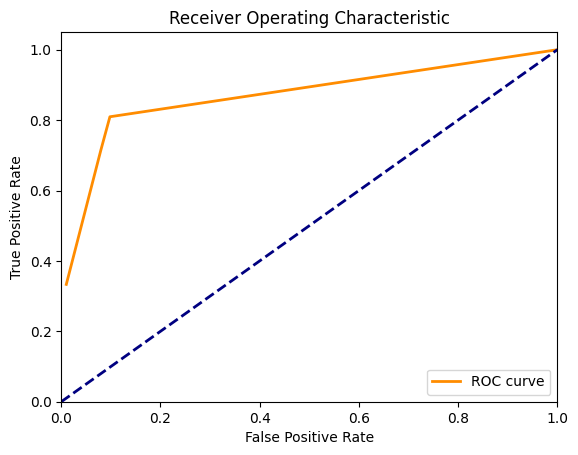

KNN Classifier AUC: 0.627360621668022


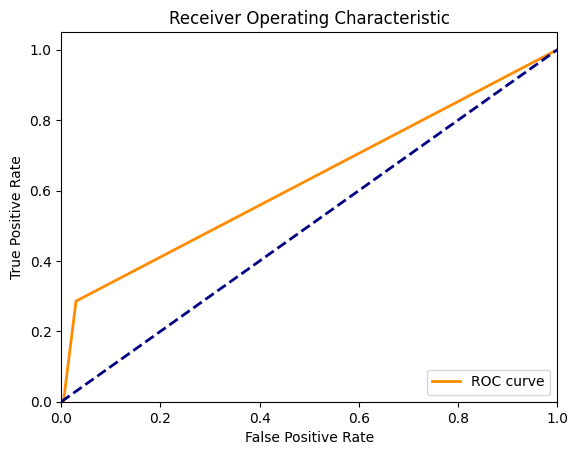

In [83]:
# Train a Decision Tree Classifier (with max depth = 2)
# Train a K-Nearest Neighbors (KNN) Classifier
# Use both classifiers to predict probabilities and then evaluate them using ROC

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

X = planets5[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
y = planets5['P_HABITABLE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

# Train K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)


# Predict probabilities
# For ROC, we need the predicted probabilities of the positive class (P_HABITABLE = 1)

# Decision Tree Probabilities (We need probabilities for the positive class)
y_prob_tree = tree_clf.predict_proba(X_test)[:, 1]

# KNN Probabilities
y_prob_knn = knn_clf.predict_proba(X_test)[:, 1]


# Evaluate using ROC functions defined above

# For Decision Tree Classifier
fpr_tree, tpr_tree, thresholds_tree = my_roc(y_test, y_prob_tree)
print("Decision Tree Classifier AUC:", calculate_auc_trapezoidal(fpr_tree, tpr_tree))
plot_roc_curve(fpr_tree, tpr_tree)

# For KNN Classifier
fpr_knn, tpr_knn, thresholds_knn = my_roc(y_test, y_prob_knn)
print("KNN Classifier AUC:", calculate_auc_trapezoidal(fpr_knn, tpr_knn))
plot_roc_curve(fpr_knn, tpr_knn)

# cross validation

* we want a better validation strategy than splitting the data into train-test

    When we pick a single train/test split, we might significantly under-/overestimate the performance of our algorithm. Instead, we would like to quote a typical performance, quantified by our evaluation metric of choice, and to also provide an estimate of the associated uncertainty coming from the statistical variability of the data. Another shortcoming of the single train/test split approach is that we effectively waste a significant amount of potential training data, since the data in the test set are not allowed to be part of the model-building process.

* The general idea of `cross validation` is that we choose several possible train/test splits and repeat the training process accordingly. The overall performance can be estimated as the mean (or median) of the test scores obtained in all the attempts, and the standard deviation (or other dispersion measure) provides an estimate of the uncertainty.

* The most common practical strategy for cross validation is `k-fold cross validation`

    It which consists of dividing the learning set into `k folds`, and "cycling through" the folds so that in each of the k iterations, we use one fold as test set, and the remaining k − 1 folds as the train set

* Through this process, we build a predictive model k times. So which one is the right, "final" model? 

    The answer, perhaps surprisingly, is none of them. The purpose of the cross validation process is to provide a fair estimate of the generalization error and its uncertainty. However, the final model will be built using the entire learning set, and therefore it might be slightly different from any of the models obtained previously.

* How many folds?

    Using a large number of realizations (folds) has multiple advantages: It makes the estimate of the mean/median and standard deviation more reliable, and it ensures that the generalization error for the final model, built on the full data set, is similar to the one reported in the cross validation process, in which the training set size is smaller. This matters especially for small data sets. However, the training time scales linearly with the number of folds, which might limit one's ability to use a large number for k. Typical k values are between 5 and 10; it is not advisable to go below 3 if at all possible.
* other CV techniques
    * `Leave-One-Out method`
    
        in which one considers as many folds as examples in the data sets, so that each training set has n − 1 objects, and each test set has only one object
    * `Leave-p-Out method`
    
        where p objects are left out for the test set, and the possible splits are permutations of (n − p) objects
    * `stratification`, the process of choosing the folds while maintaining approximately the same fractional class membership of the entire learning set.
    
        This is relevant for imbalanced classification problems. For example, if the ratio of negative:positive class members is 1/20 overall, a stratified k-fold partition will keep approximately the same ratio in all the folds.

## `StratifiedKFold`

In [84]:
# calculate the confusion matrix for each fold, 
# and then compute the required statistics (mean and standard deviation) for both accuracy and recall.

# StratifiedKFold: will ensure that each fold in cross-validation has a proportional number of classes
# RobustScaler: is robust to outliers, scaling the features by subtracting the median and dividing by the IQR

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

X = planets5[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
y = planets5['P_HABITABLE']

# Initialize StratifiedKFold and RobustScaler
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # 10 folds
scaler = RobustScaler()

# Store metrics for each fold
accuracies_tree = []
recalls_tree = []
conf_matrix_tree = []

accuracies_knn = []
recalls_knn = []
conf_matrix_knn = []

# Cross-validation loop
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale the data using RobustScaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Decision Tree
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_clf.fit(X_train_scaled, y_train)
    
    # Train KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train_scaled, y_train)
    
    # Predictions for both classifiers
    y_pred_tree = tree_clf.predict(X_test_scaled)
    y_pred_knn = knn_clf.predict(X_test_scaled)

    # Accuracy and recall for Decision Tree
    acc_tree = accuracy_score(y_test, y_pred_tree)
    rec_tree = recall_score(y_test, y_pred_tree)
    accuracies_tree.append(acc_tree)
    recalls_tree.append(rec_tree)
    
    # Confusion matrix for Decision Tree
    cm_tree = confusion_matrix(y_test, y_pred_tree, labels=[1, 0])
    conf_matrix_tree.append(cm_tree)
    
    # Accuracy and recall for KNN
    acc_knn = accuracy_score(y_test, y_pred_knn)
    rec_knn = recall_score(y_test, y_pred_knn)
    accuracies_knn.append(acc_knn)
    recalls_knn.append(rec_knn)
    
    # Confusion matrix for KNN
    cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[1, 0])
    conf_matrix_knn.append(cm_knn)

# Step 1: Compute mean and std of accuracies and recalls
mean_acc_tree = np.mean(accuracies_tree)
std_acc_tree = np.std(accuracies_tree)
mean_rec_tree = np.mean(recalls_tree)
std_rec_tree = np.std(recalls_tree)

mean_acc_knn = np.mean(accuracies_knn)
std_acc_knn = np.std(accuracies_knn)
mean_rec_knn = np.mean(recalls_knn)
std_rec_knn = np.std(recalls_knn)

# Step 2: Output results for Decision Tree
print("Decision Tree Classifier:")
print(f"Mean Accuracy: {mean_acc_tree:.2f}, Std of Accuracy: {std_acc_tree:.2f}")
print(f"Mean Recall: {mean_rec_tree:.2f}, Std of Recall: {std_rec_tree:.2f}")

# Sum confusion matrix over all folds for Decision Tree
conf_matrix_tree_sum = np.sum(conf_matrix_tree, axis=0)
TP_tree, FN_tree, FP_tree, TN_tree = conf_matrix_tree_sum.ravel()
print("Confusion Matrix (Summed over all folds):")
print(f"TP: {TP_tree}, FN: {FN_tree}, FP: {FP_tree}, TN: {TN_tree}\n")

# Step 3: Output results for KNN
print("KNN Classifier:")
print(f"Mean Accuracy: {mean_acc_knn:.2f}, Std of Accuracy: {std_acc_knn:.2f}")
print(f"Mean Recall: {mean_rec_knn:.2f}, Std of Recall: {std_rec_knn:.2f}")

# Sum confusion matrix over all folds for KNN
conf_matrix_knn_sum = np.sum(conf_matrix_knn, axis=0)
TP_knn, FN_knn, FP_knn, TN_knn = conf_matrix_knn_sum.ravel()
print("Confusion Matrix (Summed over all folds):")
print(f"TP: {TP_knn}, FN: {FN_knn}, FP: {FP_knn}, TN: {TN_knn}\n")

Decision Tree Classifier:
Mean Accuracy: 0.99, Std of Accuracy: 0.00
Mean Recall: 0.10, Std of Recall: 0.11
Confusion Matrix (Summed over all folds):
TP: 7, FN: 63, FP: 16, TN: 5253

KNN Classifier:
Mean Accuracy: 0.99, Std of Accuracy: 0.00
Mean Recall: 0.47, Std of Recall: 0.17
Confusion Matrix (Summed over all folds):
TP: 33, FN: 37, FP: 16, TN: 5253



In [85]:
print("Decision Tree Classifier:")
print(f"Mean Accuracy: {mean_acc_tree:.2f}, Std of Accuracy: {std_acc_tree:.5f}")
print("KNN Classifier:")
print(f"Mean Accuracy: {mean_acc_knn:.2f}, Std of Accuracy: {std_acc_knn:.5f}")

Decision Tree Classifier:
Mean Accuracy: 0.99, Std of Accuracy: 0.00462
KNN Classifier:
Mean Accuracy: 0.99, Std of Accuracy: 0.00325


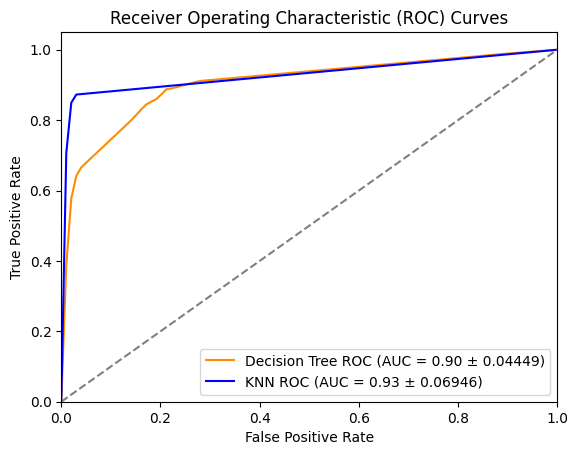

In [86]:
# whole process for binary classification

# StratifiedKFold: will ensure that each fold in cross-validation has a proportional number of classes
# RobustScaler: is robust to outliers, scaling the features by subtracting the median and dividing by the IQR
# sklearn.metrics: roc_curve and auc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc

# Prepare the data
X = planets5[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
y = planets5['P_HABITABLE']

# Initialize StratifiedKFold and RobustScaler
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scaler = RobustScaler()

# Store metrics for each fold
# for the test set
accuracies_tree = []
recalls_tree = []
conf_matrix_tree = []
accuracies_knn = []
recalls_knn = []
conf_matrix_knn = []
# for the train set
train_accuracies_tree = []
train_recalls_tree = []
train_accuracies_knn = []
train_recalls_knn = []

# For storing ROC data for both models
tprs_tree = []
tprs_knn = []
aucs_tree = []
aucs_knn = []
mean_fpr = np.linspace(0, 1, 100)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Scale the data using RobustScaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Decision Tree
    tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree_clf.fit(X_train_scaled, y_train)

    # Train KNN Classifier
    knn_clf = KNeighborsClassifier(n_neighbors=5)
    knn_clf.fit(X_train_scaled, y_train)

    # Predictions for both classifiers
    y_pred_tree = tree_clf.predict(X_test_scaled)
    y_pred_knn = knn_clf.predict(X_test_scaled)
    y_pred_train_tree = tree_clf.predict(X_train_scaled)
    y_pred_train_knn = knn_clf.predict(X_train_scaled)

    # Accuracy and recall for Decision Tree
    acc_tree = accuracy_score(y_test, y_pred_tree)
    rec_tree = recall_score(y_test, y_pred_tree)
    accuracies_tree.append(acc_tree)
    recalls_tree.append(rec_tree)
    train_acc_tree = accuracy_score(y_train, y_pred_train_tree)
    train_recall_tree = recall_score(y_train, y_pred_train_tree)
    train_accuracies_tree.append(train_acc_tree)
    train_recalls_tree.append(train_recall_tree)

    # Confusion matrix for Decision Tree
    cm_tree = confusion_matrix(y_test, y_pred_tree, labels=[1, 0])
    conf_matrix_tree.append(cm_tree)

    # Accuracy and recall for KNN
    acc_knn = accuracy_score(y_test, y_pred_knn)
    rec_knn = recall_score(y_test, y_pred_knn)
    accuracies_knn.append(acc_knn)
    recalls_knn.append(rec_knn)
    train_acc_knn = accuracy_score(y_train, y_pred_train_knn)
    train_recall_knn = recall_score(y_train, y_pred_train_knn)
    train_accuracies_knn.append(train_acc_knn)
    train_recalls_knn.append(train_recall_knn)

    # Confusion matrix for KNN
    cm_knn = confusion_matrix(y_test, y_pred_knn, labels=[1, 0])
    conf_matrix_knn.append(cm_knn)

    # Calculate probabilities for ROC curve
    y_prob_tree = tree_clf.predict_proba(X_test_scaled)[:, 1]  # Get probability for class 1
    y_prob_knn = knn_clf.predict_proba(X_test_scaled)[:, 1]    # Get probability for class 1

    # ROC curve for Decision Tree
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    aucs_tree.append(roc_auc_tree)
    # Interpolate the TPR values at the same FPR for averaging
    tprs_tree.append(np.interp(mean_fpr, fpr_tree, tpr_tree))
    tprs_tree[-1][0] = 0.0  # Ensures the first point is 0,0

    # ROC curve for KNN
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    aucs_knn.append(roc_auc_knn)
    tprs_knn.append(np.interp(mean_fpr, fpr_knn, tpr_knn))
    tprs_knn[-1][0] = 0.0

# Plot ROC curves for both classifiers

plt.figure()

# Plot for Decision Tree
mean_tpr_tree = np.mean(tprs_tree, axis=0)
mean_tpr_tree[-1] = 1.0
mean_auc_tree = np.mean(aucs_tree)
std_auc_tree = np.std(aucs_tree)

plt.plot(mean_fpr, mean_tpr_tree, color='darkorange',
         label=f'Decision Tree ROC (AUC = {mean_auc_tree:.2f} ± {std_auc_tree:.5f})')

# Plot for KNN
mean_tpr_knn = np.mean(tprs_knn, axis=0)
mean_tpr_knn[-1] = 1.0
mean_auc_knn = np.mean(aucs_knn)
std_auc_knn = np.std(aucs_knn)

plt.plot(mean_fpr, mean_tpr_knn, color='blue',
         label=f'KNN ROC (AUC = {mean_auc_knn:.2f} ± {std_auc_knn:.5f})')

# Plotting aesthetics
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## `Pipeline`

`Pipelines` allow you to bundle steps (like scaling and classification) into a single object, making your code more modular and easier to maintain. 

In [87]:
from sklearn.pipeline import Pipeline

In [88]:
# same thing using pipelines

X = planets5[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
y = planets5['P_HABITABLE']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store metrics for each fold
accuracies_tree = []
recalls_tree = []
accuracies_knn = []
recalls_knn = []

train_accuracies_tree = []
train_recalls_tree = []
train_accuracies_knn = []
train_recalls_knn = []

# For storing ROC data for both models
tprs_tree = []
tprs_knn = []
aucs_tree = []
aucs_knn = []
mean_fpr = np.linspace(0, 1, 100)

# Define the pipelines
tree_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))
])

knn_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Stratified K-Fold Cross-validation
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Decision Tree Pipeline
    tree_pipeline.fit(X_train, y_train)
    y_pred_tree = tree_pipeline.predict(X_test)
    y_pred_train_tree = tree_pipeline.predict(X_train)

    # KNN Pipeline
    knn_pipeline.fit(X_train, y_train)
    y_pred_knn = knn_pipeline.predict(X_test)
    y_pred_train_knn = knn_pipeline.predict(X_train)

    # Accuracy and recall for Decision Tree
    accuracies_tree.append(accuracy_score(y_test, y_pred_tree))
    recalls_tree.append(recall_score(y_test, y_pred_tree))
    train_accuracies_tree.append(accuracy_score(y_train, y_pred_train_tree))
    train_recalls_tree.append(recall_score(y_train, y_pred_train_tree))

    # Accuracy and recall for KNN
    accuracies_knn.append(accuracy_score(y_test, y_pred_knn))
    recalls_knn.append(recall_score(y_test, y_pred_knn))
    train_accuracies_knn.append(accuracy_score(y_train, y_pred_train_knn))
    train_recalls_knn.append(recall_score(y_train, y_pred_train_knn))

    # Get probabilities for ROC curve
    y_prob_tree = tree_pipeline.predict_proba(X_test)[:, 1]
    y_prob_knn = knn_pipeline.predict_proba(X_test)[:, 1]

    # ROC for Decision Tree
    fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    aucs_tree.append(roc_auc_tree)
    tprs_tree.append(np.interp(mean_fpr, fpr_tree, tpr_tree))
    tprs_tree[-1][0] = 0.0

    # ROC for KNN
    fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    aucs_knn.append(roc_auc_knn)
    tprs_knn.append(np.interp(mean_fpr, fpr_knn, tpr_knn))
    tprs_knn[-1][0] = 0.0

# categorical variable encoding

when using sklearn's classifier algorithms, the target variable is expected to be discrete and if it is a `nominal variable` you don't have to worry about encoding it before feeding it to the models. That means you can use the "raw labels" (no encoding) and the algorithms will do the encoding themselves and choose the best encoding for the job. The code below exemplifies this

In [89]:
# Generate synthetic binary classification data with string labels
X, y = datasets.make_classification(n_samples=200, n_features=5, n_informative=3, n_redundant=0, 
                           n_classes=2, random_state=42)

In [90]:
y[:10]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [91]:
# Convert numeric labels to string labels
y_str = pd.Series(y).map({0: 'class_a', 1: 'class_b'}).values

In [92]:
y_str[:5]

array(['class_a', 'class_a', 'class_a', 'class_a', 'class_b'],
      dtype=object)

In [93]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_str, test_size=0.3, random_state=42)

# Let's see the first few data points
print("Features (first 5 rows):\n", X_train[:5])
print("Labels (first 5 rows):\n", y_train[:5])

Features (first 5 rows):
 [[-0.94562918 -1.34000375 -0.73093004 -1.37931923 -1.64547362]
 [-1.19978653  0.15562769  0.24333945 -0.04558602  2.9527176 ]
 [ 1.41801167  1.15336547  0.19791078  1.7359638   1.0737518 ]
 [ 1.76044255 -1.44689669 -1.33534436  0.177701    1.84931296]
 [ 1.54764443 -0.05967031 -1.66096093 -0.07016571  0.60629492]]
Labels (first 5 rows):
 ['class_a' 'class_b' 'class_b' 'class_b' 'class_b']


In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [95]:
# Train and test KNN and Decision Tree classifiers without encoding (manually)

knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(random_state=42)

In [96]:
knn.fit(X_train, y_train)
tree.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_tree = tree.predict(X_test)

In [97]:
y_pred_knn[:10]

array(['class_b', 'class_b', 'class_b', 'class_b', 'class_a', 'class_a',
       'class_a', 'class_a', 'class_a', 'class_a'], dtype=object)

In [98]:
y_pred_tree[:10]

array(['class_b', 'class_b', 'class_b', 'class_b', 'class_a', 'class_a',
       'class_a', 'class_a', 'class_a', 'class_a'], dtype=object)

In [99]:
print("KNN Accuracy (without encoding):", accuracy_score(y_test, y_pred_knn))
print("Decision Tree Accuracy (without encoding):", accuracy_score(y_test, y_pred_tree))

KNN Accuracy (without encoding): 0.9166666666666666
Decision Tree Accuracy (without encoding): 0.9166666666666666


However, the algorithms will accept already encoded labels too. So you can still do it manually if you want (idk why you would but still). However, doing the encoding becomes important if:
* the variable is a input (not the target) and is not in a dataframe and marked as `categorical` - in this case it would be mistaken as a number
* when a variable is ordinal - in this case you don't want the default encoding
* when implementing algorithms yourself

## binary variable

If the variable is a string, it needs to be encoded as a number

In this case, you need to apply `LabelEncoder` to convert the string labels into numeric labels. For a binary variable, this function will convert them to $\{0, 1\}$s

https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [100]:
from sklearn.preprocessing import LabelEncoder

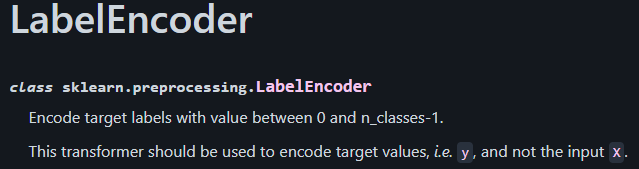

in spite of what it says, it's perfectly fine to use it for binary inputs too!

In [101]:
# Apply LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_str)

In [102]:
y_encoded[:5]

array([0, 0, 0, 0, 1])

In [103]:
np.unique(y_encoded)

array([0, 1])

As you can see, the default used a {0, 1} encoding. If you rather have {-1, 1} labels you can do

In [104]:
# Convert {0, 1} encoded labels to {-1, 1} encoding
y_neg_pos = np.where(y2 == 0, -1, 1)

In [105]:
np.unique(y_neg_pos)

array([-1,  1])

This is relevant when implementing models yourself because different encoding will result in different numerical stability in the optimization algorithms used by those models

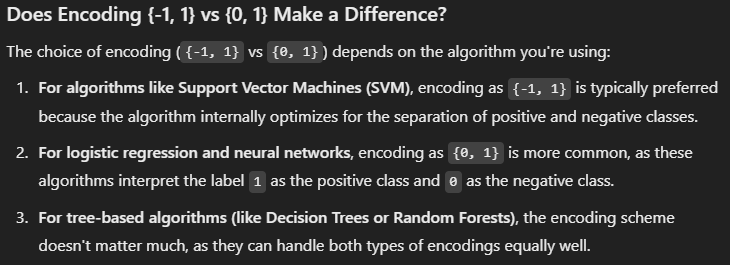

## multiclass variable

When the variable isn't binary
* if it is nominal, you should use One-hot encoding => that's `OneHotEncoder` in sklearn, or `pd.get_dummies()` in pandas
* if it is ordinal, you should integer-encode them (map them to $\mathbb{N}_0$, that is 0, 1, ...) => `OrdinalEncoder`

### one-hot encoding

Instead of encoding a nominal variables classes to $\{0, 1, 2, 3, ...\}$, you want to use one-hot encoding. This is because assinging integers to the value classes creates a implicit non-equal distance relationship between them. For eg. if you represents a class by number 0, it is closer the number 1 that represents the next class than to number 5 representing the 5th assigned class

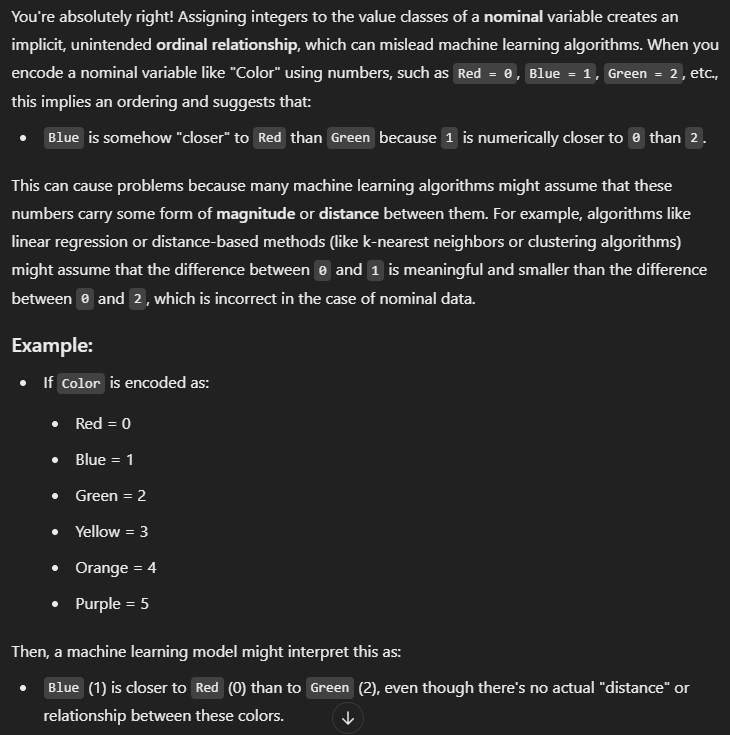

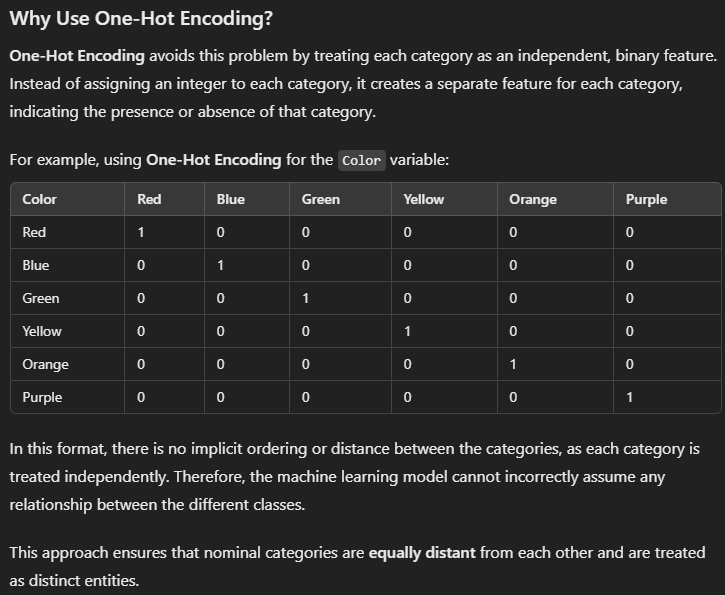

`One-hot encoding` is a technique where each class label is represented as a binary vector. Each vector has a length equal to the number of classes, and only one element is 1 (indicating the presence of the class), while all other elements are 0.

In [106]:
labels = ['cat', 'dog', 'fish']

classes = sorted(set(labels))  # Unique classes
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
print(classes)
print(class_to_index)

['cat', 'dog', 'fish']
{'cat': 0, 'dog': 1, 'fish': 2}


In [107]:
def one_hot_encode(labels):
    num_classes = len(class_to_index)
    one_hot = np.zeros((len(labels), num_classes), dtype=int)
    
    for i, label in enumerate(labels):
        one_hot[i, class_to_index[label]] = 1
    
    return one_hot

In [108]:
# One-hot encoded labels
one_hot_labels = one_hot_encode(labels)
"""
[[1 0 0]  # cat
 [0 1 0]  # dog
 [0 0 1]] # fish
"""
one_hot_labels

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

**using sklearn**

In [11]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [12]:
# Sample class labels
labels = np.array(['cat', 'dog', 'fish'])

In [13]:
# Step 1: Label Encoding - this converts each label to a unique integer
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

In [14]:
print("Integer Encoded:\n", integer_encoded.flatten())

Integer Encoded:
 [0 1 2]


In [16]:
# Step 2: One-Hot Encoding
# Reshape the data to fit the OneHotEncoder input shape
integer_encoded = integer_encoded.reshape(-1, 1)
onehot_encoder = OneHotEncoder()
one_hot_labels = onehot_encoder.fit_transform(integer_encoded)

In [17]:
print("One-Hot Encoded:\n", one_hot_labels)

One-Hot Encoded:
 <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (3, 3)>
  Coords	Values
  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0


In [18]:
# Converting the sparse matrix into a regular (dense) matrix

from scipy.sparse import csr_matrix
dense_matrix = one_hot_labels.toarray()
dense_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

For eg.

In [115]:
# Generate a synthetic multiclass dataset with 4 features, all informative
X, y = datasets.make_classification(n_samples=300, n_features=4, 
                           n_informative=4, n_redundant=0, n_repeated=0, 
                           n_classes=3, random_state=42)

In [116]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Let's see the first few data points
print("Features (first 5 rows):\n", X_train[:5])
print("Labels (first 5 rows):\n", y_train[:5])

Features (first 5 rows):
 [[-0.08289073  0.79059846  0.37185079 -0.88004144]
 [-0.48429624  0.49137442  0.42069405 -2.74980298]
 [-0.82768344  0.18030049 -0.30074703  2.6243948 ]
 [ 0.02227526 -0.98093443 -0.72342822  2.4253539 ]
 [-1.46639504  1.64306315  0.31491893  1.06017982]]
Labels (first 5 rows):
 [1 1 2 0 2]


in this case, the labels are already numbers so i can feed it directly to the models

In [117]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [118]:
# Train and test KNN and Decision Tree classifiers without encoding (manually)

knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(random_state=42)

In [119]:
knn.fit(X_train, y_train)
tree.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_tree = tree.predict(X_test)

In [120]:
print("KNN Accuracy (without encoding):", accuracy_score(y_test, y_pred_knn))
print("Decision Tree Accuracy (without encoding):", accuracy_score(y_test, y_pred_tree))

KNN Accuracy (without encoding): 0.7888888888888889
Decision Tree Accuracy (without encoding): 0.7111111111111111


again, if the labels weren't encoded yet (aka they were string labels), you don't have to but you could encode them like this

In [121]:
# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the labels (this step is redundant in this case, but useful for categorical string labels)
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [122]:
knn.fit(X_train, y_train_encoded)
tree.fit(X_train, y_train_encoded)

y_pred_knn_encoded = knn.predict(X_test)
y_pred_tree_encoded = tree.predict(X_test)

In [123]:
print("KNN Accuracy (with encoding):", accuracy_score(y_test_encoded, y_pred_knn_encoded))
print("Decision Tree Accuracy (with encoding):", accuracy_score(y_test_encoded, y_pred_tree_encoded))

KNN Accuracy (with encoding): 0.7888888888888889
Decision Tree Accuracy (with encoding): 0.7111111111111111


You only need to use `OneHotEncoder` directly if the variable is a input variable!

### integer encoding

to encode ordinary variables, you use `OrdinaryEncoder`

https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

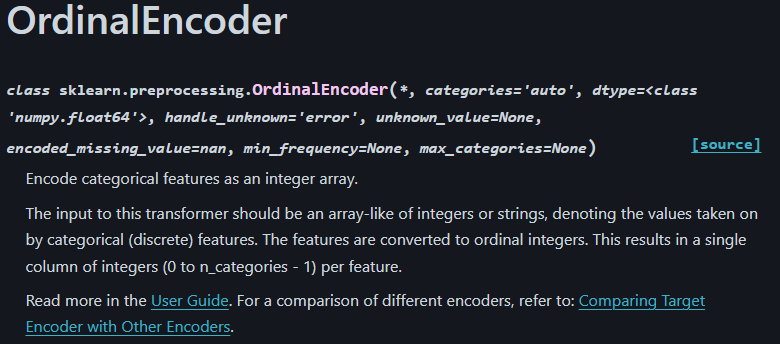

For eg.

In [28]:
from sklearn.preprocessing import OrdinalEncoder

In [20]:
data = {
    'Age': [25, 40, 30, 35, 50],  # Continuous
    'Color': ['Red', 'Blue', 'Green', 'Red', 'Blue'],  # Nominal
    'Education Level': ['High School', "Bachelor's", 'High School', "Master's", "Bachelor's"],  # Ordinal
    'Satisfaction': ['Satisfied', 'Very Satisfied', 'Neutral', 'Dissatisfied', 'Satisfied']  # Target Ordinal
}

df = pd.DataFrame(data)
df

,Age,Color,Education Level,Satisfaction
0,25,Red,High School,Satisfied
1,40,Blue,Bachelor's,Very Satisfied
2,30,Green,High School,Neutral
3,35,Red,Master's,Dissatisfied
4,50,Blue,Bachelor's,Satisfied


In [26]:
# Step 1: Encode the nominal variable "Color" using OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)
color_encoded = onehot_encoder.fit_transform(df[['Color']])

# Convert one-hot encoded columns to a DataFrame
color_encoded_df = pd.DataFrame(color_encoded, columns=onehot_encoder.get_feature_names_out(['Color']))
color_encoded_df

,Color_Blue,Color_Green,Color_Red
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,1.0,0.0,0.0


In [31]:
# Step 2: Encode the ordinal input "Education Level" using OrdinalEncoder with a custom mapping
education_mapping = ['High School', "Bachelor's", "Master's"]
ordinal_encoder = OrdinalEncoder(categories=[education_mapping])
education_encoded = ordinal_encoder.fit_transform(df[['Education Level']])
education_encoded

array([[0.],
       [1.],
       [0.],
       [2.],
       [1.]])

In [33]:
# Step 3: Encode the target ordinal variable "Satisfaction" using OrdinalEncoder with a custom mapping
satisfaction_mapping = ['Dissatisfied', 'Neutral', 'Satisfied', 'Very Satisfied']
target_encoder = OrdinalEncoder(categories=[satisfaction_mapping])
satisfaction_encoded = target_encoder.fit_transform(df[['Satisfaction']])
satisfaction_encoded

array([[2.],
       [3.],
       [1.],
       [0.],
       [2.]])

In [35]:
# Combine all the features together
df_encoded = pd.concat([df[['Age']], color_encoded_df, pd.DataFrame(education_encoded, columns=['Education Level'])], axis=1)
df_encoded

,Age,Color_Blue,Color_Green,Color_Red,Education Level
0,25,0.0,0.0,1.0,0.0
1,40,1.0,0.0,0.0,1.0
2,30,0.0,1.0,0.0,0.0
3,35,0.0,0.0,1.0,2.0
4,50,1.0,0.0,0.0,1.0


In [36]:
# The target variable (Satisfaction) should be separated for training the model
target = pd.DataFrame(satisfaction_encoded, columns=['Satisfaction'])

# multiclass classification evaluation

For multiclass problems, accuracy is still easily interpretable and applicable as the total number of correct classifications. Similarly, we can build the confusion matrix without ambiguities; it will be n × n (instead of 2×2)

* However, evaluation metrics like precision and recall rely on the concept of a "positive" class, so if we want to employ them, it is necessary to rephrase their definitions in a framework akin to binary classification.

* The most common approach is the one-versus-all. In this formalism, we start by assigning the "positive class" label to one of the classes and consider all remaining elements as members of the negative class. We can then build an "effective" binary classifier, for which any metric can be calculated. We continue this process by cycling through all classes, regarding each of them as the positive class once. This gives us n estimates of metrics for an n-class problem

    Let's assume we are interested in precision for this example’s sake, since we will use the explicit definition below, and let’s call them $P_1, P_2, \ldots, P_n$. The final step is to average the performances to obtain one final estimate $P = \frac{1}{n} \sum_{i=1}^n P_i$, that is, an arithmetic mean of the n estimates, independent of class size; this is called `macro averaging`.
    
    Alternatively, we can perform the average at the building blocks level $P = \Large\frac{TP_1 + TP_2 + \ldots + TP_n}{TP_1 + TP_2 + \ldots + TP_n + FP_1 + FP_2 + \ldots + FP_n}$, called `micro averaging`

* another explanation: consider what it means to be accurate and precise when there's multiple targets in the "darts" example above

In [124]:
# 3 classes
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]

y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [125]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[2, 0, 0],
       [1, 0, 1],
       [0, 2, 0]])

most scorers have multiple options

In [126]:
# eg. using the f1
from sklearn.metrics import f1_score

## no averaging

No averaging
* When average=None, the function returns the F1 score for each class individually.
* This gives you detailed insights into the performance for each class rather than aggregating them into a single score.

In [127]:
f1_no_avg = f1_score(y_true, y_pred, average=None) # # F1 scores for class 0, class 1, and class 2
f1_no_avg

array([0.8, 0. , 0. ])

## macro averaging

Macro averaging computes the F1 score for each class independently and then takes the unweighted mean of these scores.
* It treats all classes equally, giving equal importance to all classes regardless of how many samples each class has.
* It's useful when you want to treat all classes as equally important, even if some classes are smaller than others.

In [128]:
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_macro

np.float64(0.26666666666666666)

In [129]:
np.mean(f1_no_avg)

np.float64(0.26666666666666666)

## micro averaging

Micro averaging aggregates the contributions of all classes to calculate the F1 score by computing the total true positives, false negatives, and false positives across all classes.
* It essentially calculates a global F1 score as if we were performing a binary classification on the entire dataset.
* This method gives more weight to larger classes, as it considers the overall number of true and false classifications.

In [130]:
f1_score(y_true, y_pred, average='micro')

np.float64(0.3333333333333333)

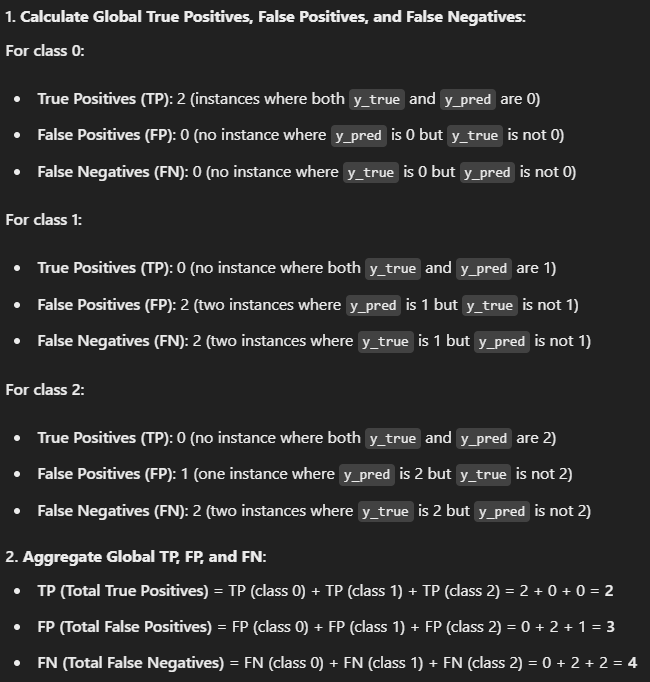

In [131]:
tp = np.zeros(3)  # True positives for classes 0, 1, and 2
fp = np.zeros(3)
fn = np.zeros(3)

# Calculate TP, FP, and FN for each class
for class_label in range(3):
    tp[class_label] = np.sum((y_true == class_label) & (y_pred == class_label))  # True Positives
    fp[class_label] = np.sum((y_pred == class_label) & (y_true != class_label))  # False Positives
    fn[class_label] = np.sum((y_true == class_label) & (y_pred != class_label))  # False Negatives

print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

# aggregates
tp_tot = sum(tp)
fp_tot = sum(fp)
fn_tot = sum(fn)

# precision(tp, fp), recall(tp, fn)
precision = my_precision(tp_tot, fp_tot)
recall = my_recall(tp_tot, fn_tot)
f1_micro = my_f1_score(precision, recall)
f1_micro

True Positives: [2. 0. 0.]
False Positives: [1. 2. 1.]
False Negatives: [0. 2. 2.]


np.float64(0.3333333333333333)

## weighted averaging

Weighted averaging calculates the F1 score for each class, but the contribution of each class to the final score is weighted by the number of true instances in that class (i.e., the class frequency in the true data).
* This is particularly useful when there's a class imbalance, as it accounts for the support (number of true instances) of each class, giving larger classes more influence in the final score.

In [132]:
n_true_0s = np.sum(y_true==0)
n_true_1s = np.sum(y_true==1)
n_true_2s = np.sum(y_true==2)
n_tot = len(y_true)

In [133]:
f1_score(y_true, y_pred, average='weighted')

np.float64(0.26666666666666666)

In [134]:
f1_no_avg[0] * n_true_0s/n_tot + f1_no_avg[1] * n_true_1s/n_tot + f1_no_avg[2] * n_true_2s/n_tot

np.float64(0.26666666666666666)

# diagnosing supervised classification

## overfitting, underfitting

* [Peter Bartlett - Benign overfitting](https://www.youtube.com/watch?v=MZFXVGGB11E)
* [Neil Mallinar - taxonomy of overfitting](https://www.youtube.com/watch?v=cg9s7jpWgck)

* If a model is able to make accurate predictions on unseen data, we say it is able to `generalize` from the training set to the test set. We want to build a model that is able to generalize as accurately as possible.

* `overfitting`: high variance

    Building a model that is too complex for the amount of information we have is called overfitting. Overfitting occurs when you fit a model too closely to the particularities of the training set and obtain a model that works well on the training set but is not able to generalize to new data.

    A model that suffers from high variance generalizes poorly, because it has been excessively tailored to its training set. This often happens when the model is excessively complex; perhaps it’s trying to fit simple input/output relationships with highly flexible methods, with the result of "absorbing" all the nooks and crannies of the training set, including random fluctuations and outliers. Another possibility is that it's been fed a lot of information (features) that are not helpful and act as noise. 

* `underfitting`: high bias

    underfitting is the inverse of overfitting, meaning that the statistical model or machine learning algorithm is too simplistic to accurately capture the patterns in the data.
    
    A model that suffers from high bias cannot capture the complexity of the input-output relationship (in other words, it’s too simplistic). It might be because of the algorithm that we chose (e.g., we are using a linear model to capture a nonlinear relationship), or because the features that we have are not relevant or informative enough, or because we don’t have enough data

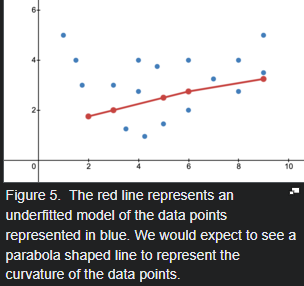

The possibility of over-fitting exists because the criterion used for selecting the model is not the same as the criterion used to judge the suitability of a model. For example, a model might be selected by maximizing its performance on some set of training data, and yet its suitability might be determined by its ability to perform well on unseen data; overfitting occurs when a model begins to "memorize" training data rather than "learning" to generalize from a trend.

As an extreme example, if the number of parameters is the same as or greater than the number of observations, then a model can perfectly predict the training data simply by memorizing the data in its entirety. Such a model, though, will typically fail severely when making predictions.

To lessen the chance or amount of overfitting, several techniques are available (e.g., `model comparison`, `cross-validation`, `regularization`, `early stopping`, `pruning`, `Bayesian priors`, or `dropout`). The basis of some techniques is to either (1) explicitly penalize overly complex models or (2) test the model's ability to generalize by evaluating its performance on a set of data not used for training, which is assumed to approximate the typical unseen data that a model will encounter.

The larger variety of data points your dataset contains, the more complex a model you can use without overfitting. Usually, collecting more data points will yield more variety, so larger datasets allow building more complex models. However, simply duplicating the same data points or collecting very similar data will not help.

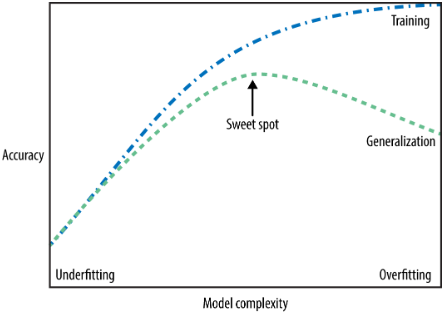

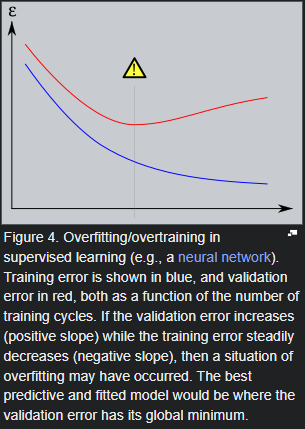

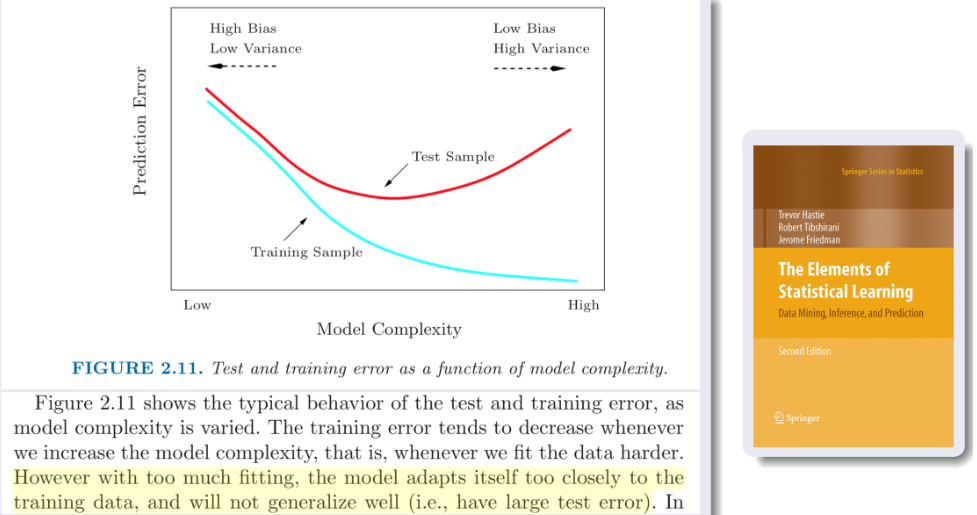

* "`benign overfitting`"

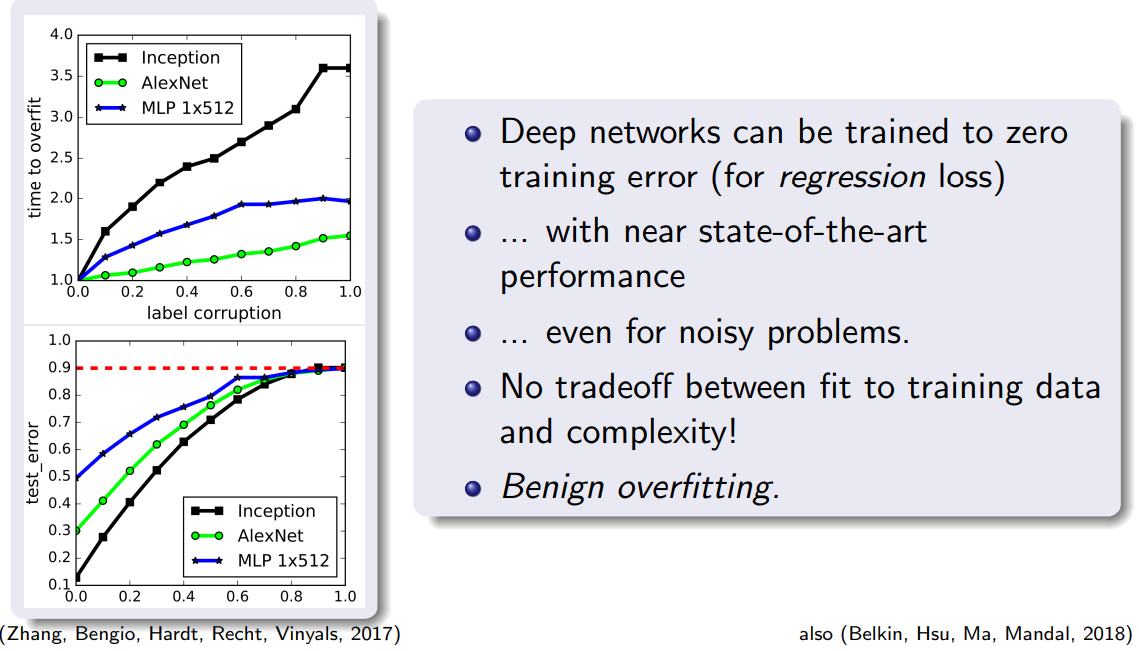

## learning curves

* `learning curves` are used to estimate how the performance of the model is tied to the size of the learning set.

    Intuitively, if our learning set is very small, models won’t be able to capture the input/output relationship correctly and will have low test scores. As we add more data, their performance would improve until a plateau is reached when the data have enough variance to maximize the information available from the provided features. After this point, adding more data (in the sense of adding more data with identical features and distribution of the current data) won't help any more
    
* obtained by plotting the test scores from the cross-validation process, for different sizes of the learning set

    Often both the train and test scores are plotted, so that one can use a single plot to evaluate variance/bias and determine whether more data would be helpful). By looking at whether our current learning set size lies in the "slope-y" or "flat" part of the curve, we can gauge the impact of gathering additional data

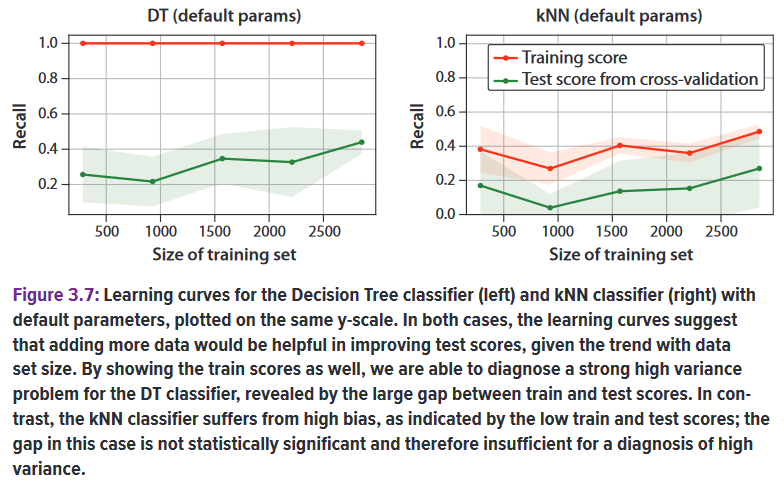

if i'm using cross-validation, the training set size remains constant for each split. But this technique is useful to decide before hand if the current size of the learning set is enough

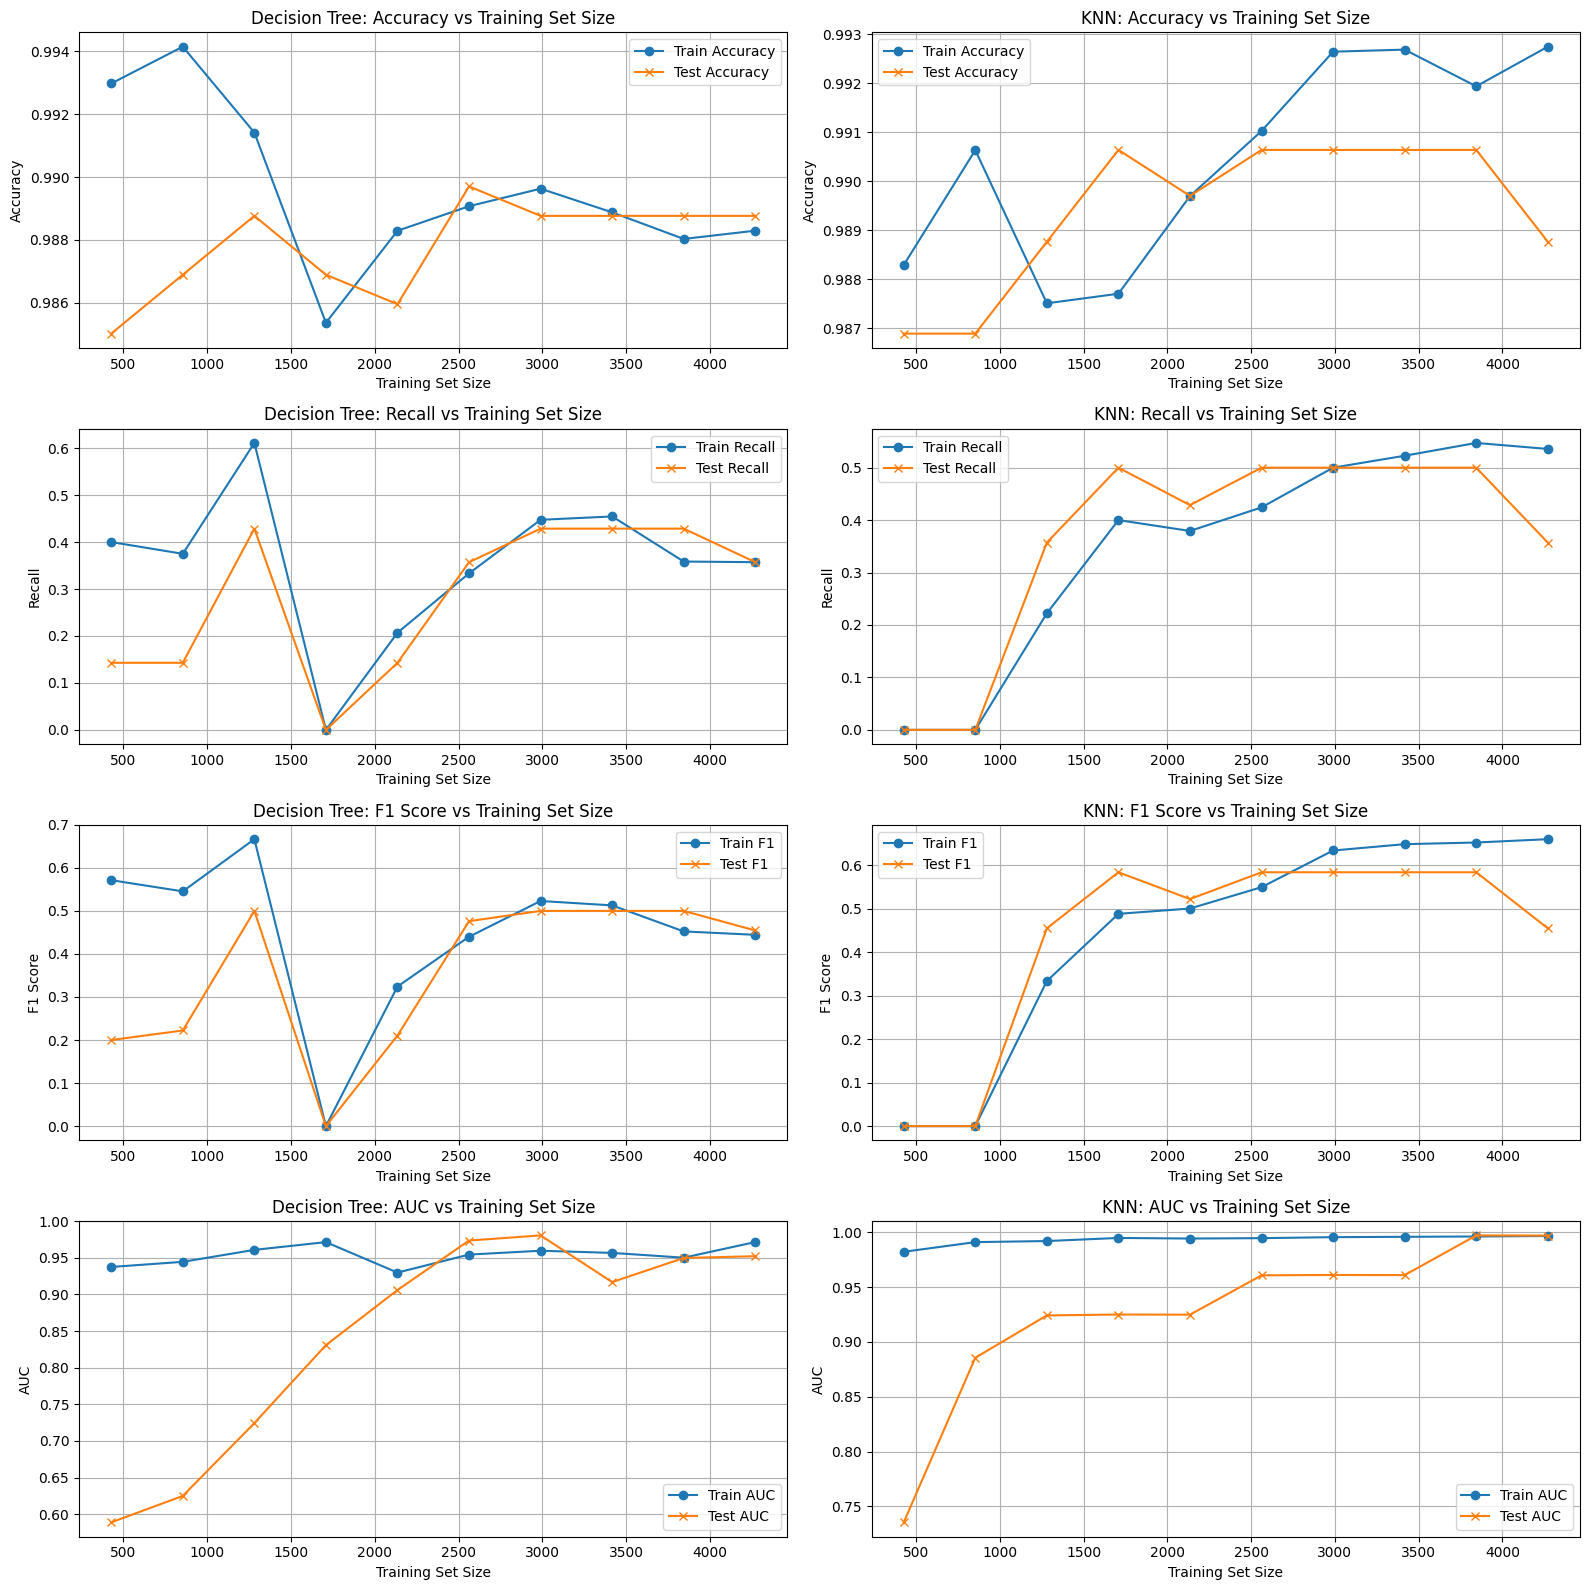

In [135]:
from sklearn.metrics import roc_auc_score

X = planets5[['S_MASS', 'P_PERIOD', 'P_DISTANCE']]
y = planets5['P_HABITABLE']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the data using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Store metrics for different training sizes
train_sizes = np.arange(0.1, 1.1, 0.1) * len(X_train)  # 10% to 100% of training data
train_accuracies_tree = []
train_recalls_tree = []
train_f1_tree = []
train_auc_tree = []
test_accuracies_tree = []
test_recalls_tree = []
test_f1_tree = []
test_auc_tree = []

train_accuracies_knn = []
train_recalls_knn = []
train_f1_knn = []
train_auc_knn = []
test_accuracies_knn = []
test_recalls_knn = []
test_f1_knn = []
test_auc_knn = []

# Learning curve evaluation
for size in train_sizes:
    size = int(size)  # Convert to integer
    # Use a subset of the training data
    X_train_subset = X_train_scaled[:size]
    y_train_subset = y_train[:size]
    
    # Train Decision Tree
    tree_clf.fit(X_train_subset, y_train_subset)
    
    # Predictions for Decision Tree
    y_train_pred_tree = tree_clf.predict(X_train_subset)
    y_test_pred_tree = tree_clf.predict(X_test_scaled)
    y_train_prob_tree = tree_clf.predict_proba(X_train_subset)[:, 1]  # Probabilities for AUC
    y_test_prob_tree = tree_clf.predict_proba(X_test_scaled)[:, 1]    # Probabilities for AUC

    # Calculate training and test scores for Decision Tree
    train_accuracies_tree.append(accuracy_score(y_train_subset, y_train_pred_tree))
    train_recalls_tree.append(recall_score(y_train_subset, y_train_pred_tree))
    train_f1_tree.append(f1_score(y_train_subset, y_train_pred_tree))
    train_auc_tree.append(roc_auc_score(y_train_subset, y_train_prob_tree))
    
    test_accuracies_tree.append(accuracy_score(y_test, y_test_pred_tree))
    test_recalls_tree.append(recall_score(y_test, y_test_pred_tree))
    test_f1_tree.append(f1_score(y_test, y_test_pred_tree))
    test_auc_tree.append(roc_auc_score(y_test, y_test_prob_tree))

    # Train KNN Classifier
    knn_clf.fit(X_train_subset, y_train_subset)
    
    # Predictions for KNN
    y_train_pred_knn = knn_clf.predict(X_train_subset)
    y_test_pred_knn = knn_clf.predict(X_test_scaled)
    y_train_prob_knn = knn_clf.predict_proba(X_train_subset)[:, 1]  # Probabilities for AUC
    y_test_prob_knn = knn_clf.predict_proba(X_test_scaled)[:, 1]    # Probabilities for AUC

    # Calculate training and test scores for KNN
    train_accuracies_knn.append(accuracy_score(y_train_subset, y_train_pred_knn))
    train_recalls_knn.append(recall_score(y_train_subset, y_train_pred_knn))
    train_f1_knn.append(f1_score(y_train_subset, y_train_pred_knn))
    train_auc_knn.append(roc_auc_score(y_train_subset, y_train_prob_knn))
    
    test_accuracies_knn.append(accuracy_score(y_test, y_test_pred_knn))
    test_recalls_knn.append(recall_score(y_test, y_test_pred_knn))
    test_f1_knn.append(f1_score(y_test, y_test_pred_knn))
    test_auc_knn.append(roc_auc_score(y_test, y_test_prob_knn))

# Plotting Learning Curves
plt.figure(figsize=(16, 16))

# Accuracy plots
plt.subplot(4, 2, 1)
plt.plot(train_sizes, train_accuracies_tree, label='Train Accuracy', marker='o')
plt.plot(train_sizes, test_accuracies_tree, label='Test Accuracy', marker='x')
plt.title('Decision Tree: Accuracy vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(4, 2, 2)
plt.plot(train_sizes, train_accuracies_knn, label='Train Accuracy', marker='o')
plt.plot(train_sizes, test_accuracies_knn, label='Test Accuracy', marker='x')
plt.title('KNN: Accuracy vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Recall plots
plt.subplot(4, 2, 3)
plt.plot(train_sizes, train_recalls_tree, label='Train Recall', marker='o')
plt.plot(train_sizes, test_recalls_tree, label='Test Recall', marker='x')
plt.title('Decision Tree: Recall vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Recall')
plt.legend()
plt.grid()

plt.subplot(4, 2, 4)
plt.plot(train_sizes, train_recalls_knn, label='Train Recall', marker='o')
plt.plot(train_sizes, test_recalls_knn, label='Test Recall', marker='x')
plt.title('KNN: Recall vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('Recall')
plt.legend()
plt.grid()

# F1 Score plots
plt.subplot(4, 2, 5)
plt.plot(train_sizes, train_f1_tree, label='Train F1', marker='o')
plt.plot(train_sizes, test_f1_tree, label='Test F1', marker='x')
plt.title('Decision Tree: F1 Score vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()

plt.subplot(4, 2, 6)
plt.plot(train_sizes, train_f1_knn, label='Train F1', marker='o')
plt.plot(train_sizes, test_f1_knn, label='Test F1', marker='x')
plt.title('KNN: F1 Score vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()

# AUC plots
plt.subplot(4, 2, 7)
plt.plot(train_sizes, train_auc_tree, label='Train AUC', marker='o')
plt.plot(train_sizes, test_auc_tree, label='Test AUC', marker='x')
plt.title('Decision Tree: AUC vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.legend()
plt.grid()

plt.subplot(4, 2, 8)
plt.plot(train_sizes, train_auc_knn, label='Train AUC', marker='o')
plt.plot(train_sizes, test_auc_knn, label='Test AUC', marker='x')
plt.title('KNN: AUC vs Training Set Size')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In short, these metrics, especiallu the AUC should be useful to decide on a appropriate data size with which we can do cross validation later. It seems in this case, the models could do with even more data (at least it's not clear if they have plateaued)

Ways to improve the model like hyperparameter tuning and feature selection and engineering, will be for another notebook